In [150]:
import argparse
import os
import random
import time

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# dataframes
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
# from PIL import Image
# import matplotlib.animation as animation
# from IPython.display import HTML

# signal processing
from scipy import signal
# import pywt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [151]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-15-10.net.auckland.ac.nz


In [152]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 300

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

Getting parameters such as data mean and sd for standardisation

In [153]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')

# probability of augmenting data
aug_p = 0.5

# y-axis processing
# distance = 3.086e22
# gw_df = gw_df / distance

gw_mean = gw_df.mean().mean()
print('Dataset mean: ',  gw_mean)

gw_std = gw_df.std().mean()
print('Dataset std: ',  gw_std)

gw_scaling_factor = 5
print('Dataset scaling factor (to match noise in generator): ',  gw_scaling_factor)

Dataset mean:  -0.04824243411562023
Dataset std:  28.792067898778328
Dataset scaling factor (to match noise in generator):  5


Dataset mean:  -0.048529666
Dataset std:  31.921024
Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 1, 512])


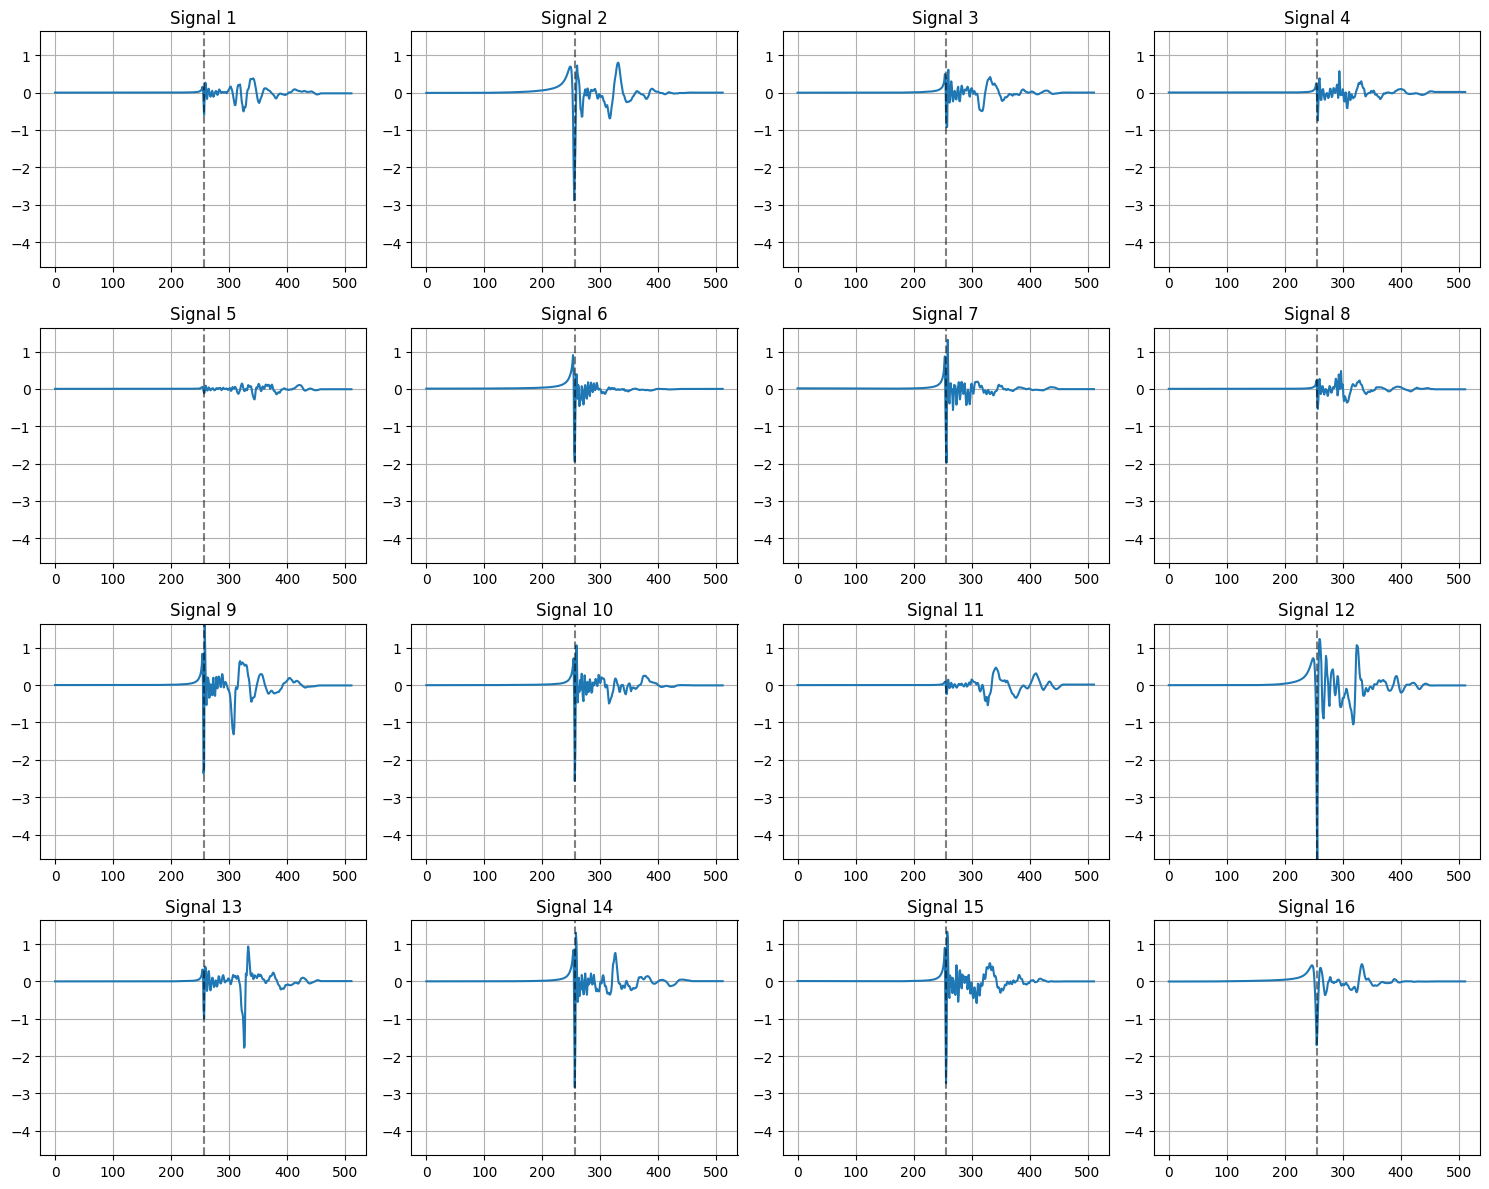

In [173]:
class GWDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).astype('float32')
        self.data = self.data.values

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal

    # def pad_signals(self):
    #     desired_length = 512
    #     augmented_signals = np.empty((desired_length, self.data.shape[1]), dtype=int)

    #     for i in range(self.data.shape[1]):
    #         signal = self.data[:, i]
    #         signal = signal.reshape(1, -1)

    #         padding_left = (desired_length - len(signal[0])) // 2
    #         padding_right = desired_length - len(signal[0]) - padding_left

    #         signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

    #         augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], signal_padded, axis=1)

    #     self.data = augmented_signals
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal

    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 50, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal

        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203

        # noise = np.random.normal(0, 0.05, signal.shape[1] - noise_start_time)
        # jittered_signal = signal[noise_start_time:] + noise
        noise = np.random.normal(0, 5, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_1 - signal_2)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # don't warp anything before the core-bounce
        warp_start_time = 203
        select_idx = signal
        # make the window 10% of the original data
        window_size = signal.shape[1] / 10

        # Ensure that the range is within bounds
        random_start = np.random.randint(lower_limit, upper_limit - i + 1)
        random_range = np.arange(random_start, random_start + i)
        
        return warped_signal

    def augmentation(self, desired_augmented_data_count):
        augmented_signals = self.data.copy()

        while augmented_signals.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            # idx_2 = np.random.randint(0, self.data.shape[1])
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            augmented_signal = self.scale_augmentation(signal_1)

            augmented_signals = np.insert(augmented_signals, augmented_signals.shape[1], augmented_signal, axis=1)

        self.data = augmented_signals

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        # process signal from strain * distance (10 kpc) -> just strain
        # distance = 3.086e22
        # signal = signal / distance

        # reshape signal to have first 512 - 407 values to be 0.
        desired_length = 512

        padding_left = (desired_length - len(signal[0])) // 2
        padding_right = desired_length - len(signal[0]) - padding_left

        signal_padded = np.pad(signal, ((0, 0), (padding_left, padding_right)), mode='edge')

        signal_standardized = self.standardize(signal_padded)

        return signal_standardized

dataset = GWDataset("../data/gw-raw-data/richers_1764.csv")
common_ylim_signal = dataset.get_common()
# dataset.pad_signals()
dataset.augmentation(6000)
dataset.calc_stats()
# dataset.standardize()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_batch = next(iter(dataloader))

# Expecting: (32, 1, 512)
print(real_batch.shape)

common_ylim = (real_batch[:,:,:].min(), real_batch[:,:,:].max())

def plot_and_save_waveforms(real_batch, filename='waveforms.png'):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_batch.size(dim=2))
        y = real_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)
    
    for i in range(512, 8*4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

plot_and_save_waveforms(real_batch, filename='../data/gw-dcgans-plots/real_data.png')

In [171]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [156]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [157]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(nz, ngf * 64, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(ngf * 64),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 64, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 32),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 16),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.LeakyReLU(True),

            nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, x):
        # print(x.shape)
        x = self.main(x)
        return x

In [158]:
# # Create the generator
netG = Generator().to(device)
netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(300, 4096, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(4096, 2048, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), b

### Discriminator

In [159]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False),
            )

            # fully conencted layer to output probability
            self.fc = nn.Sequential(
                nn.Dropout(0.25),
                nn.Sigmoid()
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            # print(x)
            return x

elif (gans_type == "wgans"):
    class Critic(nn.Module):
        def __init__(self):
            super(Critic, self).__init__()
            self.main = nn.Sequential(
                # xl kernel, stride and padding on this one (first layer group)
                nn.Conv1d(nc, ndf, kernel_size=8, stride=4, padding=2, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25),

                # xl kernel, stride and padding on this one (last layer group)
                nn.Conv1d(ndf * 32, nc, kernel_size=8,
                        stride=4, padding=2, bias=False),
            )

        def forward(self, x, y=None):
            # print(x.shape)
            x = self.main(x)
            # print(x.shape)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            # x = self.fc(x)
            # print(x)
            return x

In [160]:
if (gans_type == "dcgans"):
    netD = Discriminator().to(device)
    netD.apply(weights_init)

    print(netD)

    model = Discriminator()
    summary(model, input_size=(1, 512))

elif (gans_type == "wgans"):
    netC = Critic().to(device)
    netC.apply(weights_init)

    print(netC)

    model = Critic()
    summary(model, input_size=(1, 512))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.25, inp

### Loss functions and Optimisers

In [161]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

Starting Training Loop...
[0/20][0/188]	Loss_D: 1.9995	Loss_G: 0.7697	D(x): 0.3549	D(G(z)): 0.3985 / 0.3867
[0/20][50/188]	Loss_D: 0.8442	Loss_G: 2.8344	D(x): 0.1522	D(G(z)): 0.7179 / 0.7346
[0/20][100/188]	Loss_D: 0.8851	Loss_G: 2.2223	D(x): 0.1104	D(G(z)): 0.7702 / 0.6851
[0/20][150/188]	Loss_D: 0.6682	Loss_G: 2.0918	D(x): 0.1354	D(G(z)): 0.7070 / 0.7094


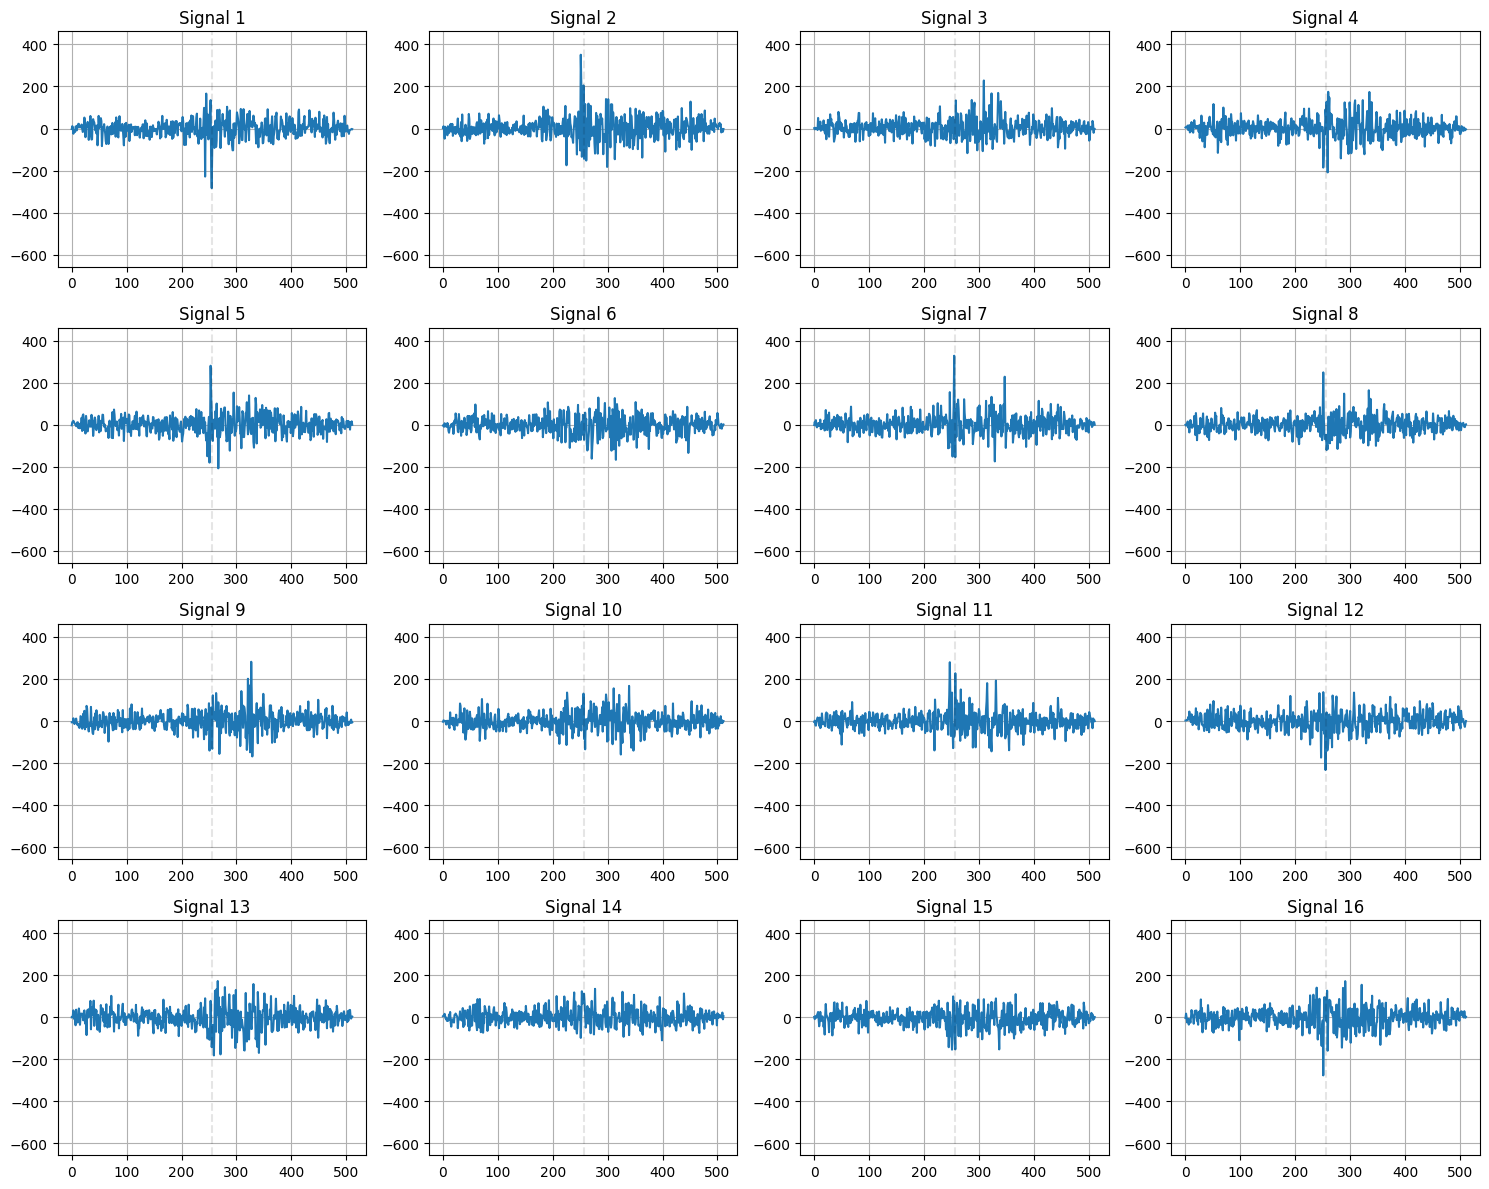

[1/20][0/188]	Loss_D: 0.9142	Loss_G: 3.1220	D(x): 0.0998	D(G(z)): 0.8356 / 0.8215
[1/20][50/188]	Loss_D: 1.0765	Loss_G: 3.8779	D(x): 0.2099	D(G(z)): 0.8298 / 0.8493
[1/20][100/188]	Loss_D: 1.2423	Loss_G: 2.2746	D(x): 0.0995	D(G(z)): 0.6766 / 0.6714
[1/20][150/188]	Loss_D: 0.3835	Loss_G: 2.0079	D(x): 0.1333	D(G(z)): 0.7137 / 0.6300


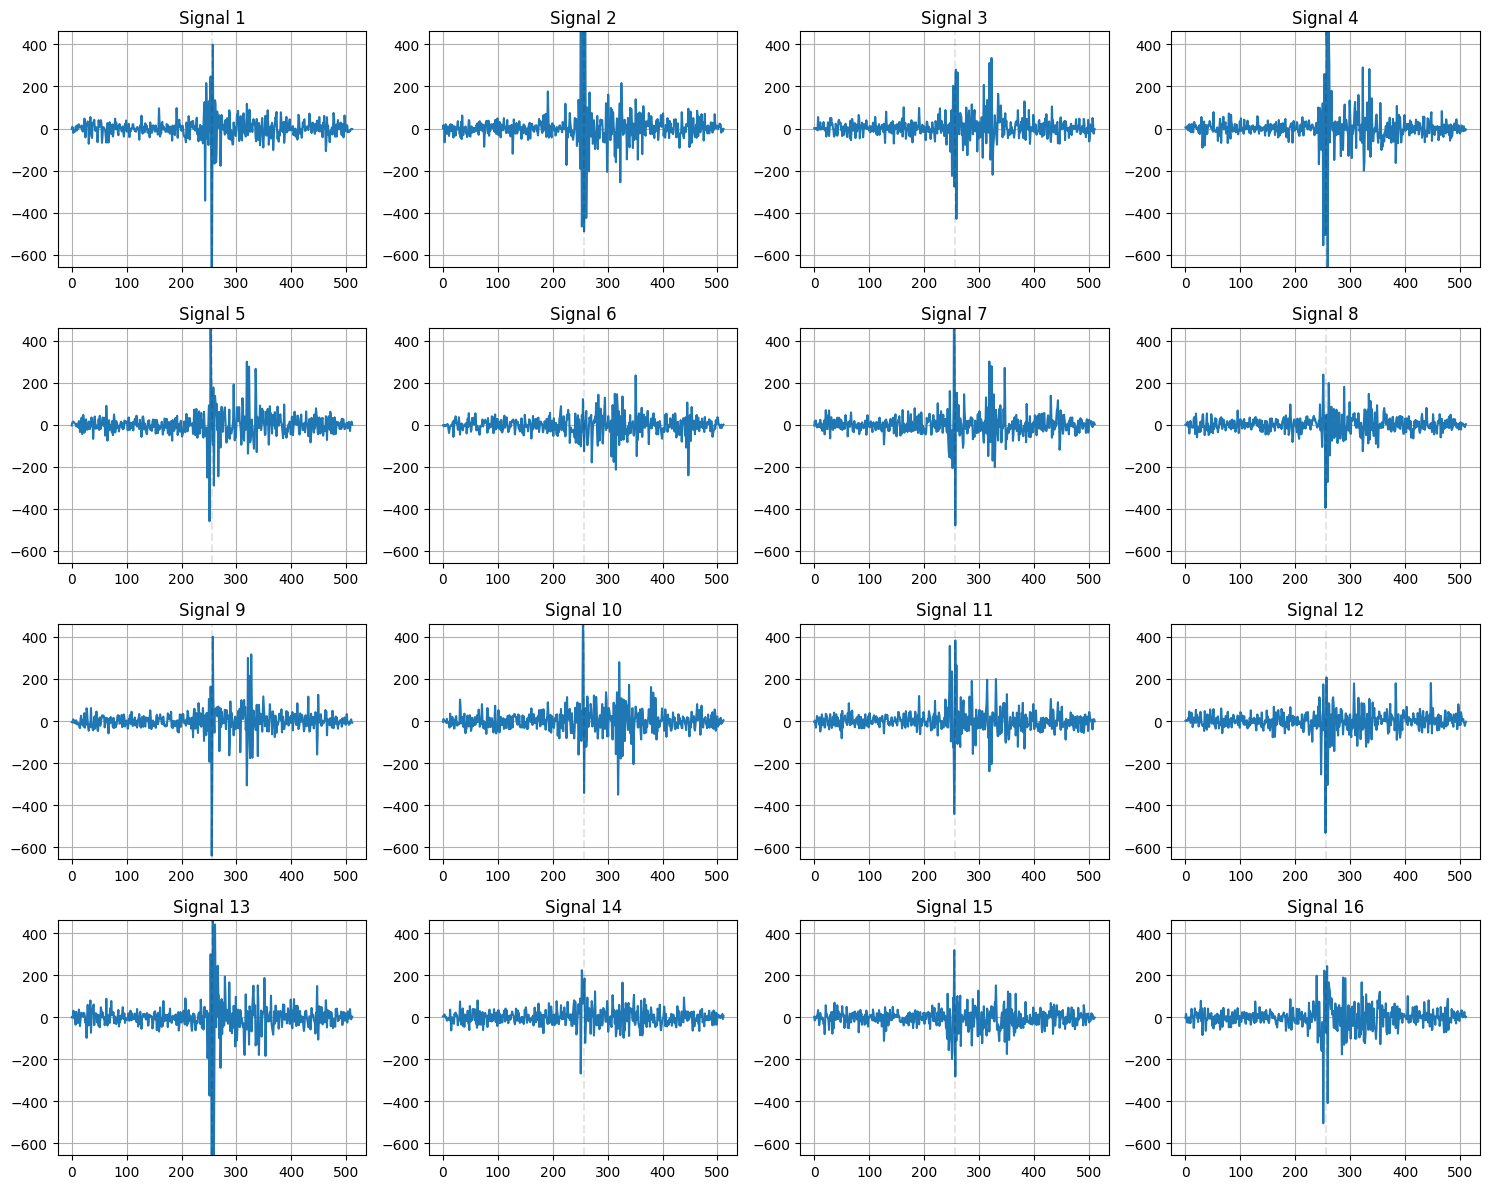

[2/20][0/188]	Loss_D: 0.9110	Loss_G: 2.9208	D(x): 0.1570	D(G(z)): 0.7939 / 0.8180
[2/20][50/188]	Loss_D: 0.6532	Loss_G: 2.4119	D(x): 0.1282	D(G(z)): 0.6883 / 0.7671
[2/20][100/188]	Loss_D: 1.1550	Loss_G: 3.6088	D(x): 0.1376	D(G(z)): 0.8211 / 0.8044
[2/20][150/188]	Loss_D: 0.8491	Loss_G: 2.4415	D(x): 0.1737	D(G(z)): 0.7198 / 0.7373


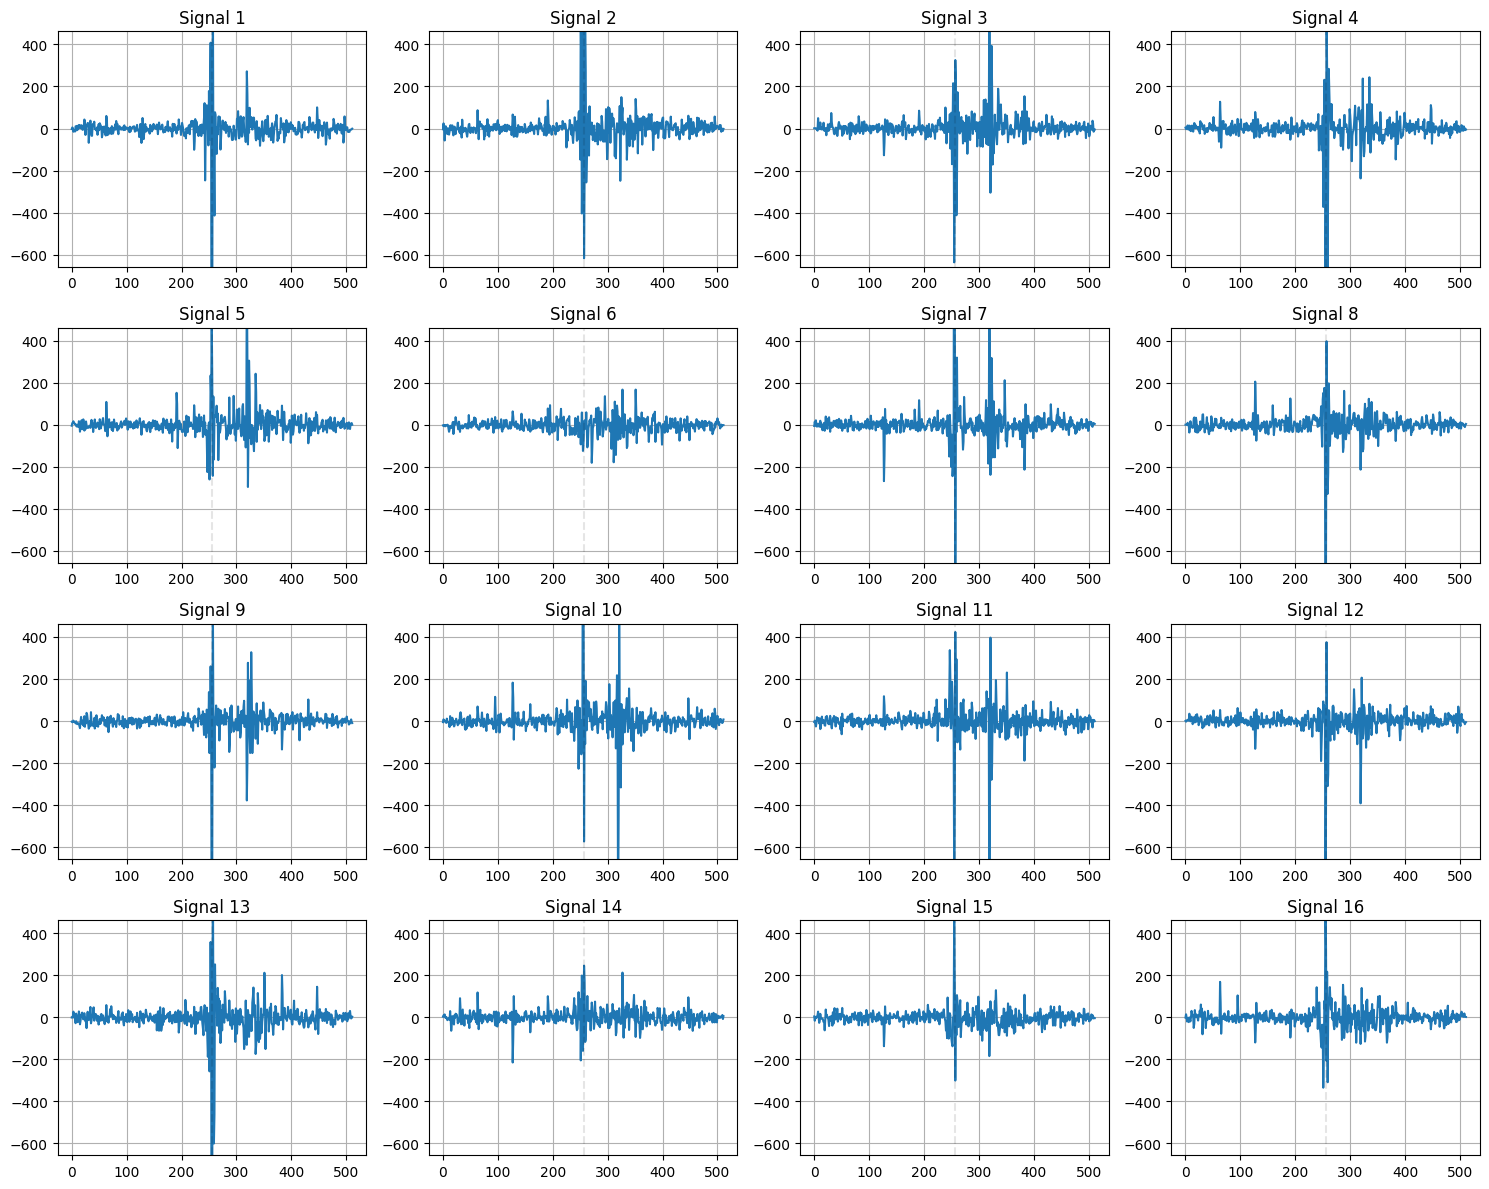

[3/20][0/188]	Loss_D: 0.9260	Loss_G: 2.7784	D(x): 0.1489	D(G(z)): 0.7777 / 0.8106
[3/20][50/188]	Loss_D: 0.5516	Loss_G: 2.1413	D(x): 0.1878	D(G(z)): 0.7824 / 0.7216
[3/20][100/188]	Loss_D: 0.9110	Loss_G: 2.7613	D(x): 0.0991	D(G(z)): 0.8376 / 0.7961
[3/20][150/188]	Loss_D: 0.8667	Loss_G: 2.1529	D(x): 0.1571	D(G(z)): 0.8223 / 0.7724


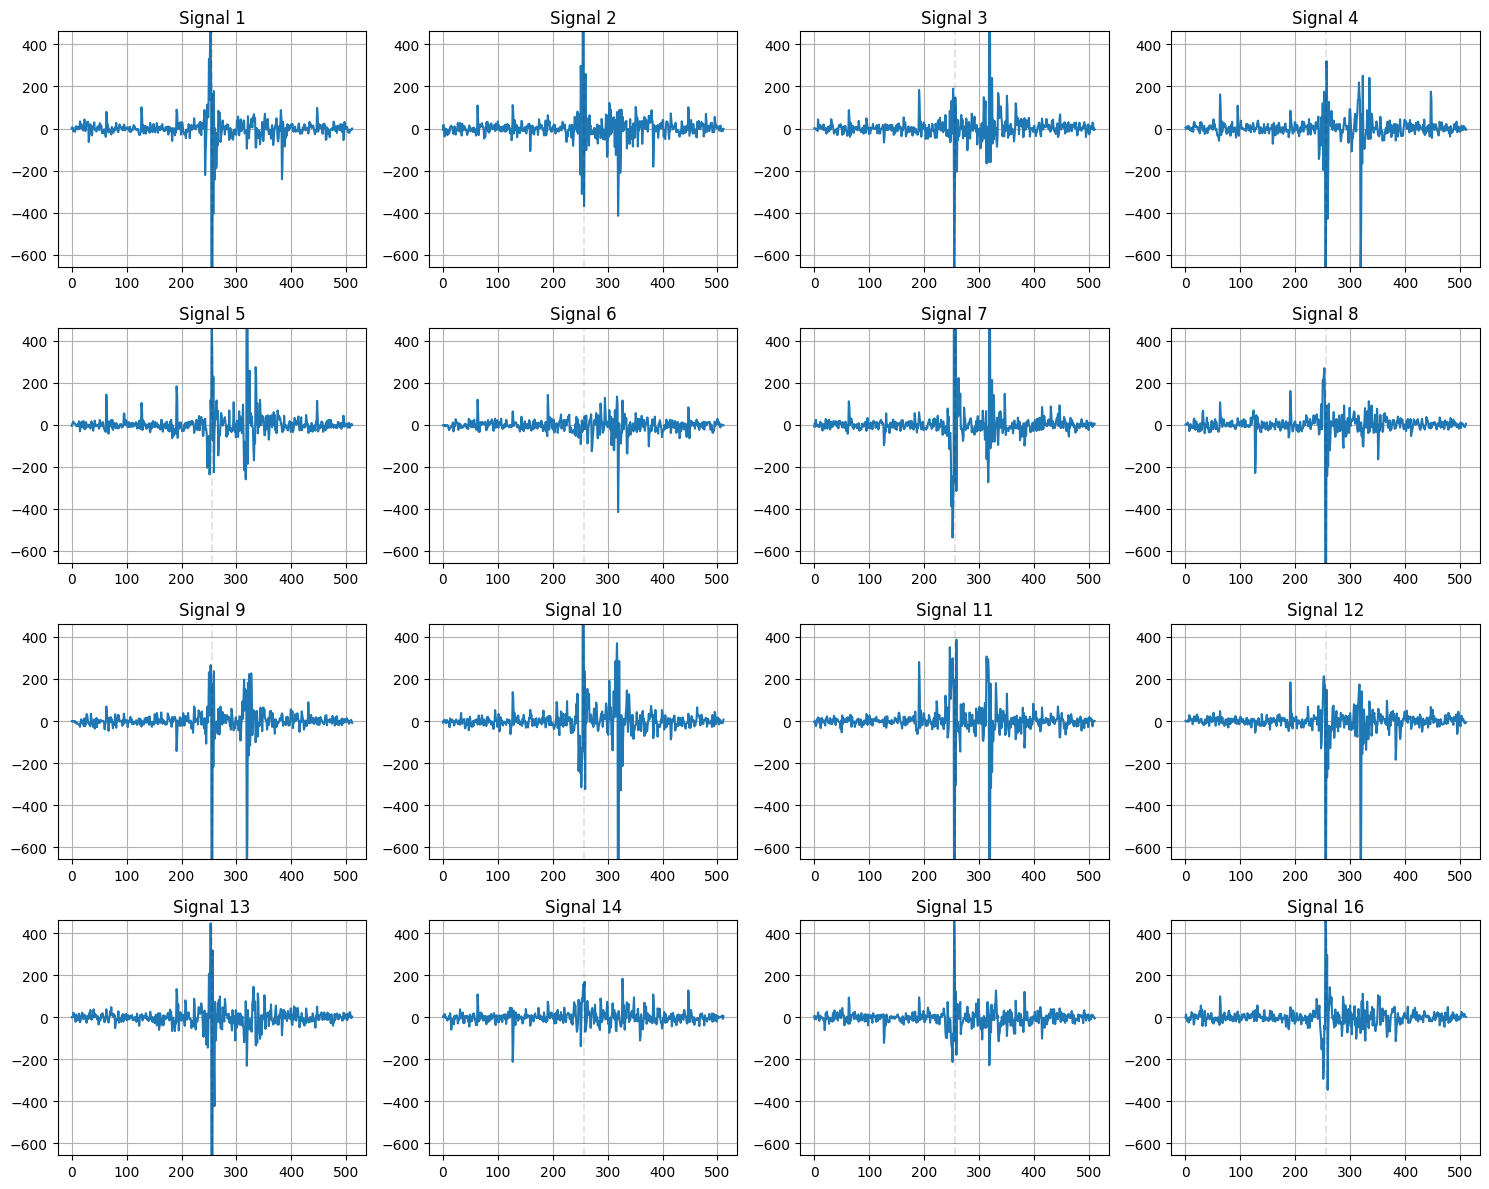

[4/20][0/188]	Loss_D: 0.9675	Loss_G: 2.6267	D(x): 0.1901	D(G(z)): 0.6799 / 0.7587
[4/20][50/188]	Loss_D: 0.7096	Loss_G: 2.6400	D(x): 0.0968	D(G(z)): 0.7562 / 0.7782
[4/20][100/188]	Loss_D: 0.6840	Loss_G: 2.5314	D(x): 0.1427	D(G(z)): 0.7818 / 0.7636
[4/20][150/188]	Loss_D: 0.8114	Loss_G: 3.2228	D(x): 0.0951	D(G(z)): 0.8704 / 0.8393


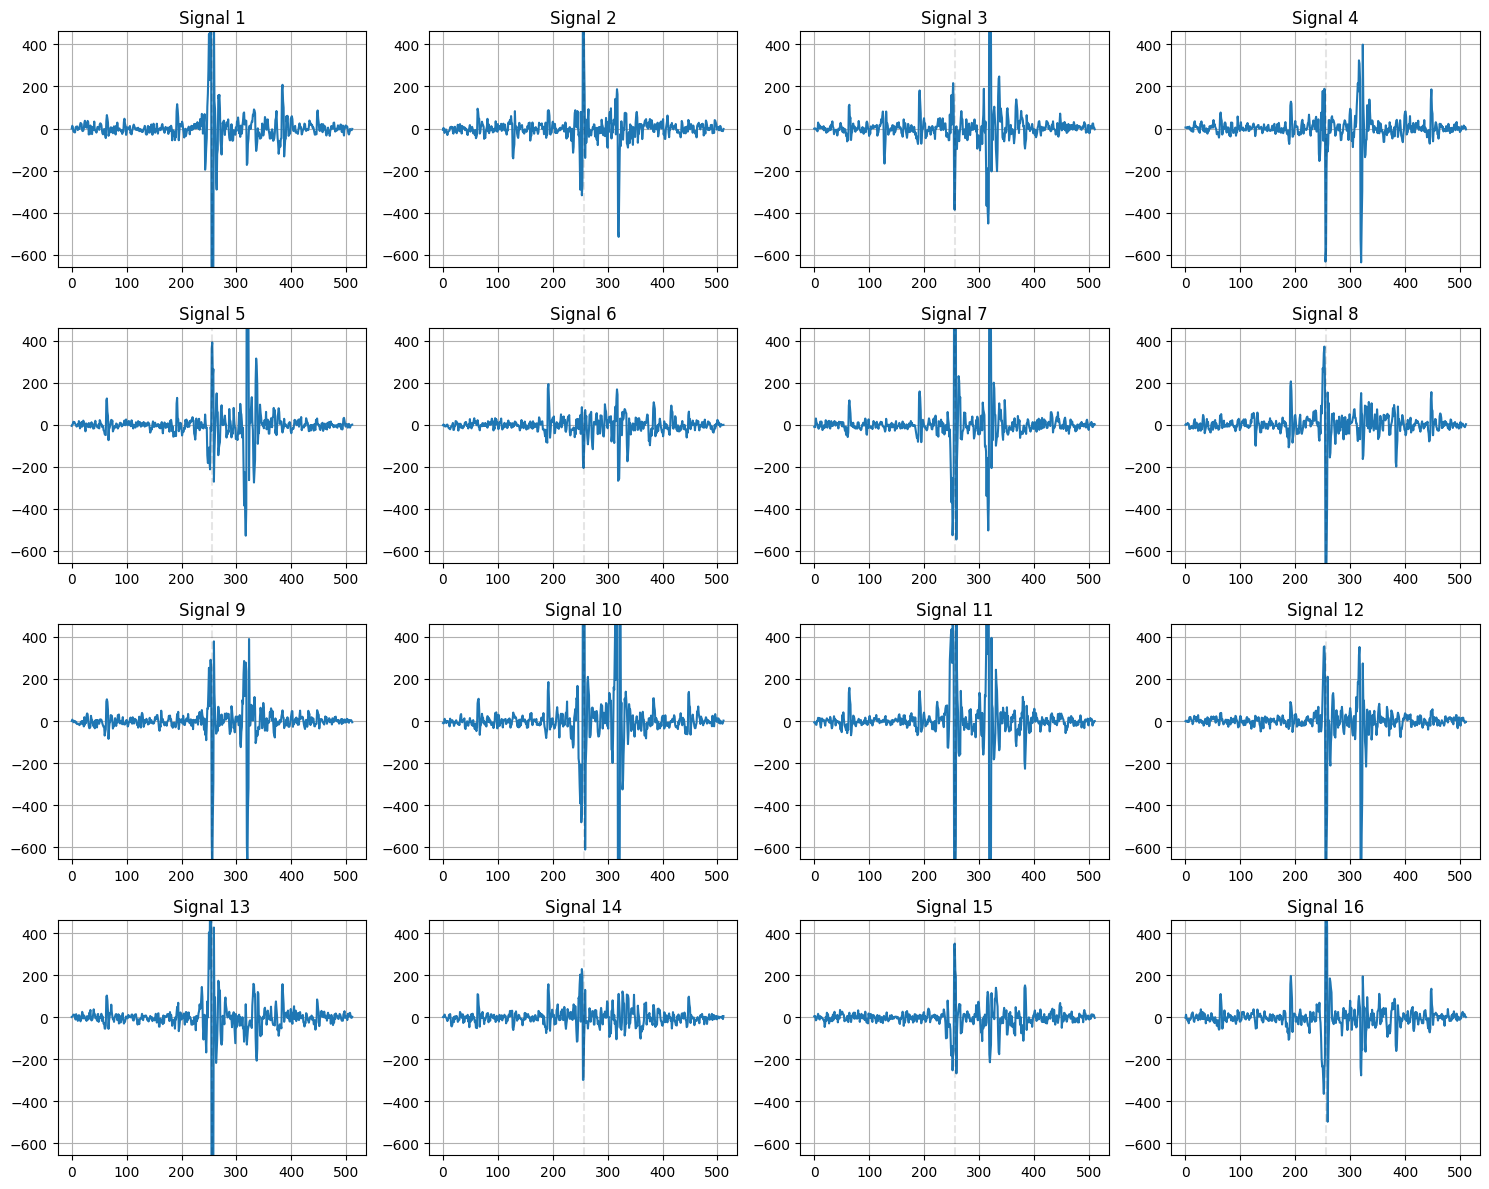

[5/20][0/188]	Loss_D: 1.0679	Loss_G: 2.1758	D(x): 0.1895	D(G(z)): 0.5727 / 0.7501
[5/20][50/188]	Loss_D: 0.8564	Loss_G: 3.8600	D(x): 0.1828	D(G(z)): 0.7870 / 0.8694
[5/20][100/188]	Loss_D: 0.5058	Loss_G: 2.2616	D(x): 0.1005	D(G(z)): 0.8273 / 0.7268
[5/20][150/188]	Loss_D: 0.9070	Loss_G: 3.5627	D(x): 0.1438	D(G(z)): 0.8566 / 0.8151


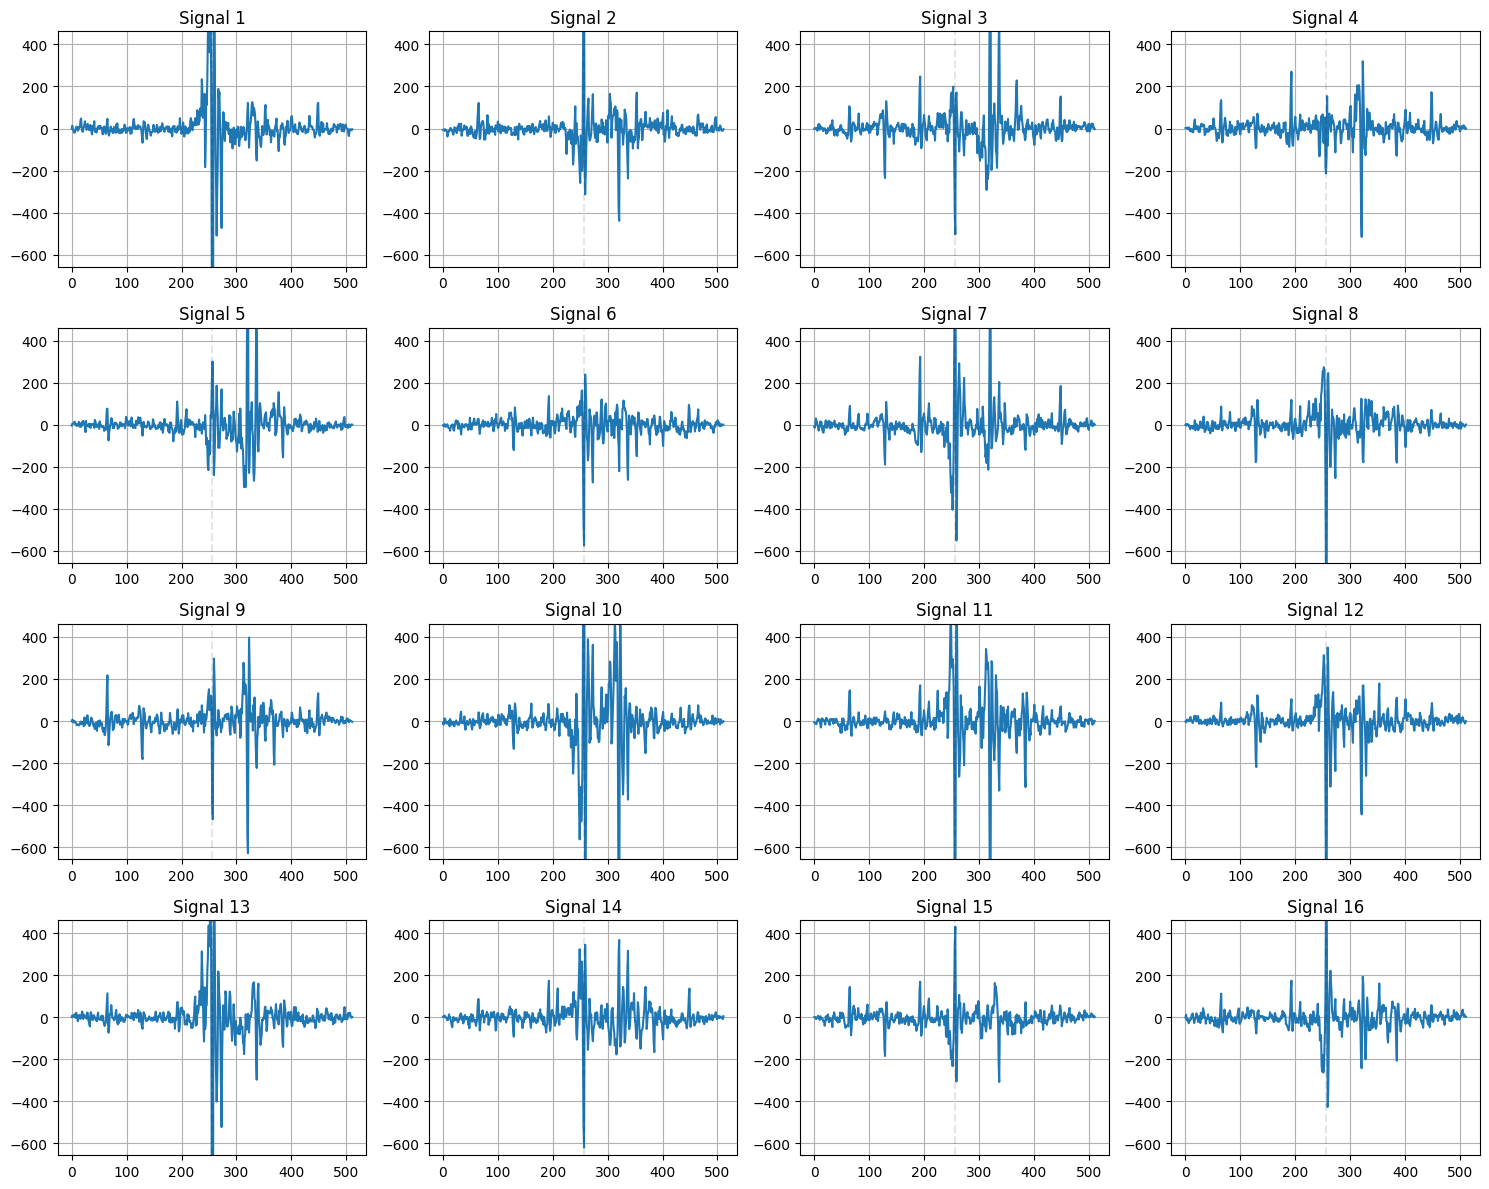

[6/20][0/188]	Loss_D: 0.6828	Loss_G: 2.8502	D(x): 0.1778	D(G(z)): 0.8010 / 0.7959
[6/20][50/188]	Loss_D: 0.9762	Loss_G: 4.2532	D(x): 0.0865	D(G(z)): 0.5834 / 0.8781
[6/20][100/188]	Loss_D: 0.8548	Loss_G: 2.3429	D(x): 0.1912	D(G(z)): 0.8012 / 0.7737
[6/20][150/188]	Loss_D: 0.8301	Loss_G: 1.6087	D(x): 0.1897	D(G(z)): 0.8158 / 0.6366


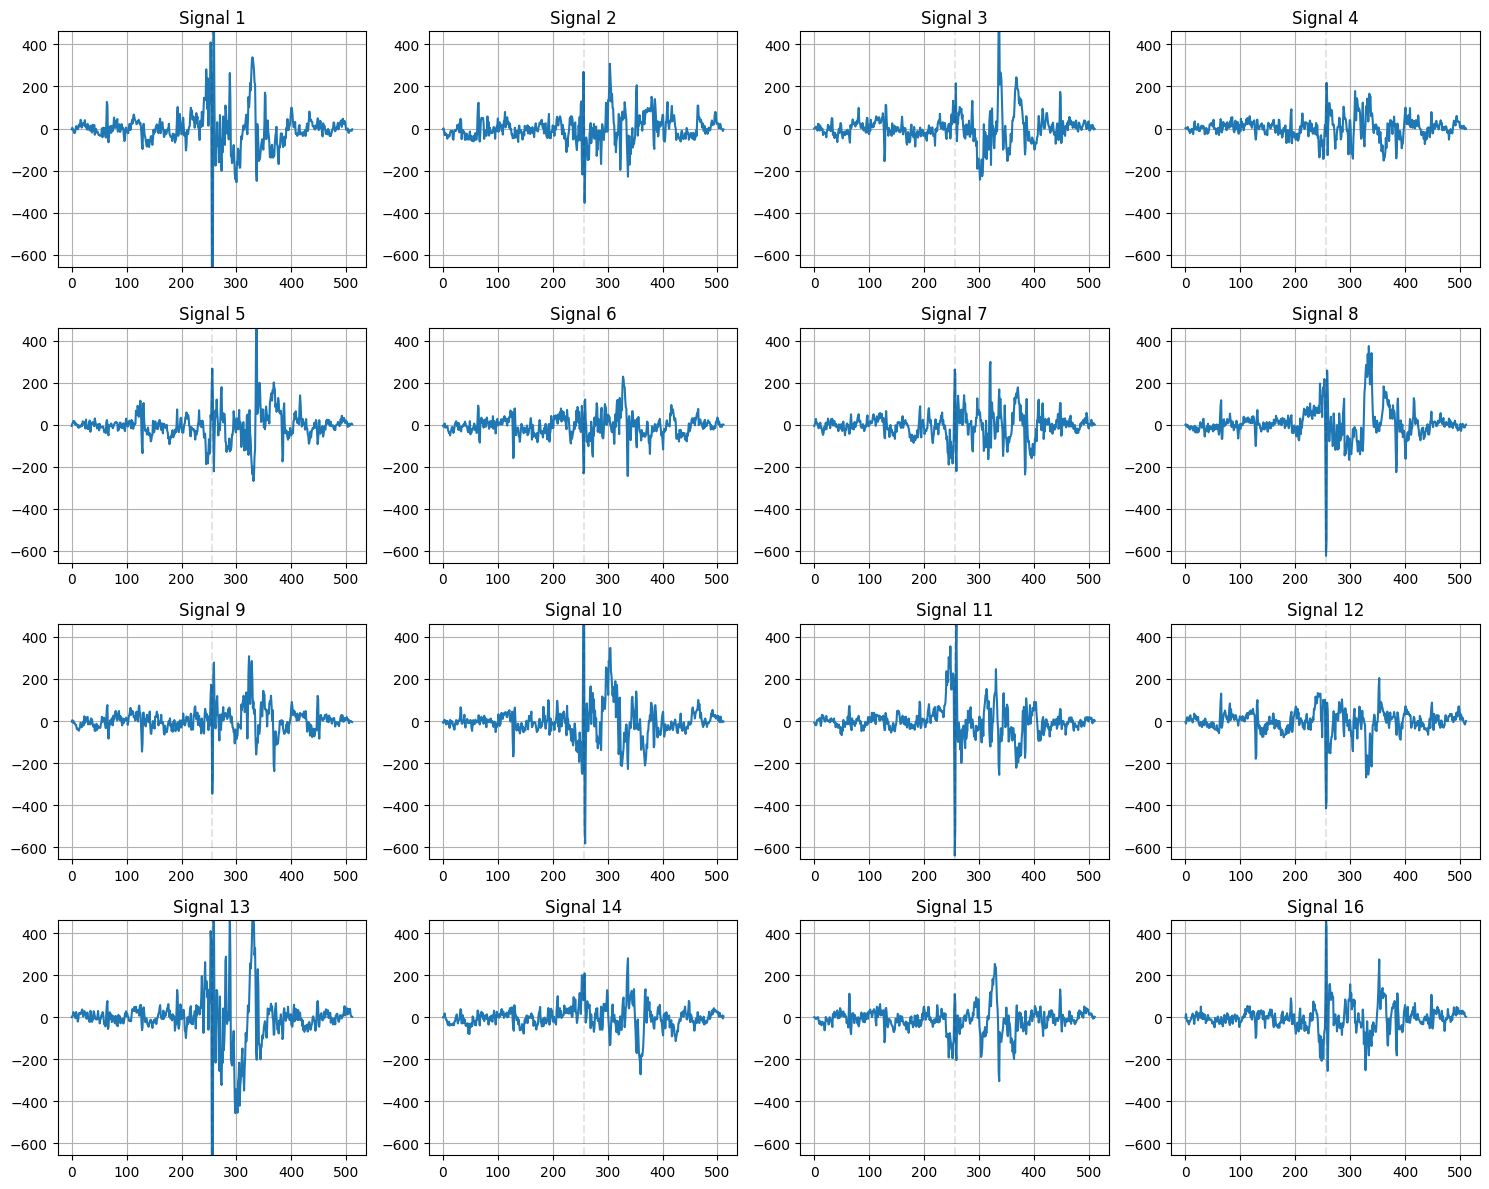

[7/20][0/188]	Loss_D: 1.1991	Loss_G: 4.2039	D(x): 0.1827	D(G(z)): 0.7867 / 0.8813
[7/20][50/188]	Loss_D: 0.9078	Loss_G: 4.0168	D(x): 0.1778	D(G(z)): 0.8386 / 0.8216
[7/20][100/188]	Loss_D: 0.5251	Loss_G: 3.6481	D(x): 0.1152	D(G(z)): 0.7375 / 0.8808
[7/20][150/188]	Loss_D: 0.9593	Loss_G: 1.6491	D(x): 0.1301	D(G(z)): 0.5248 / 0.6386


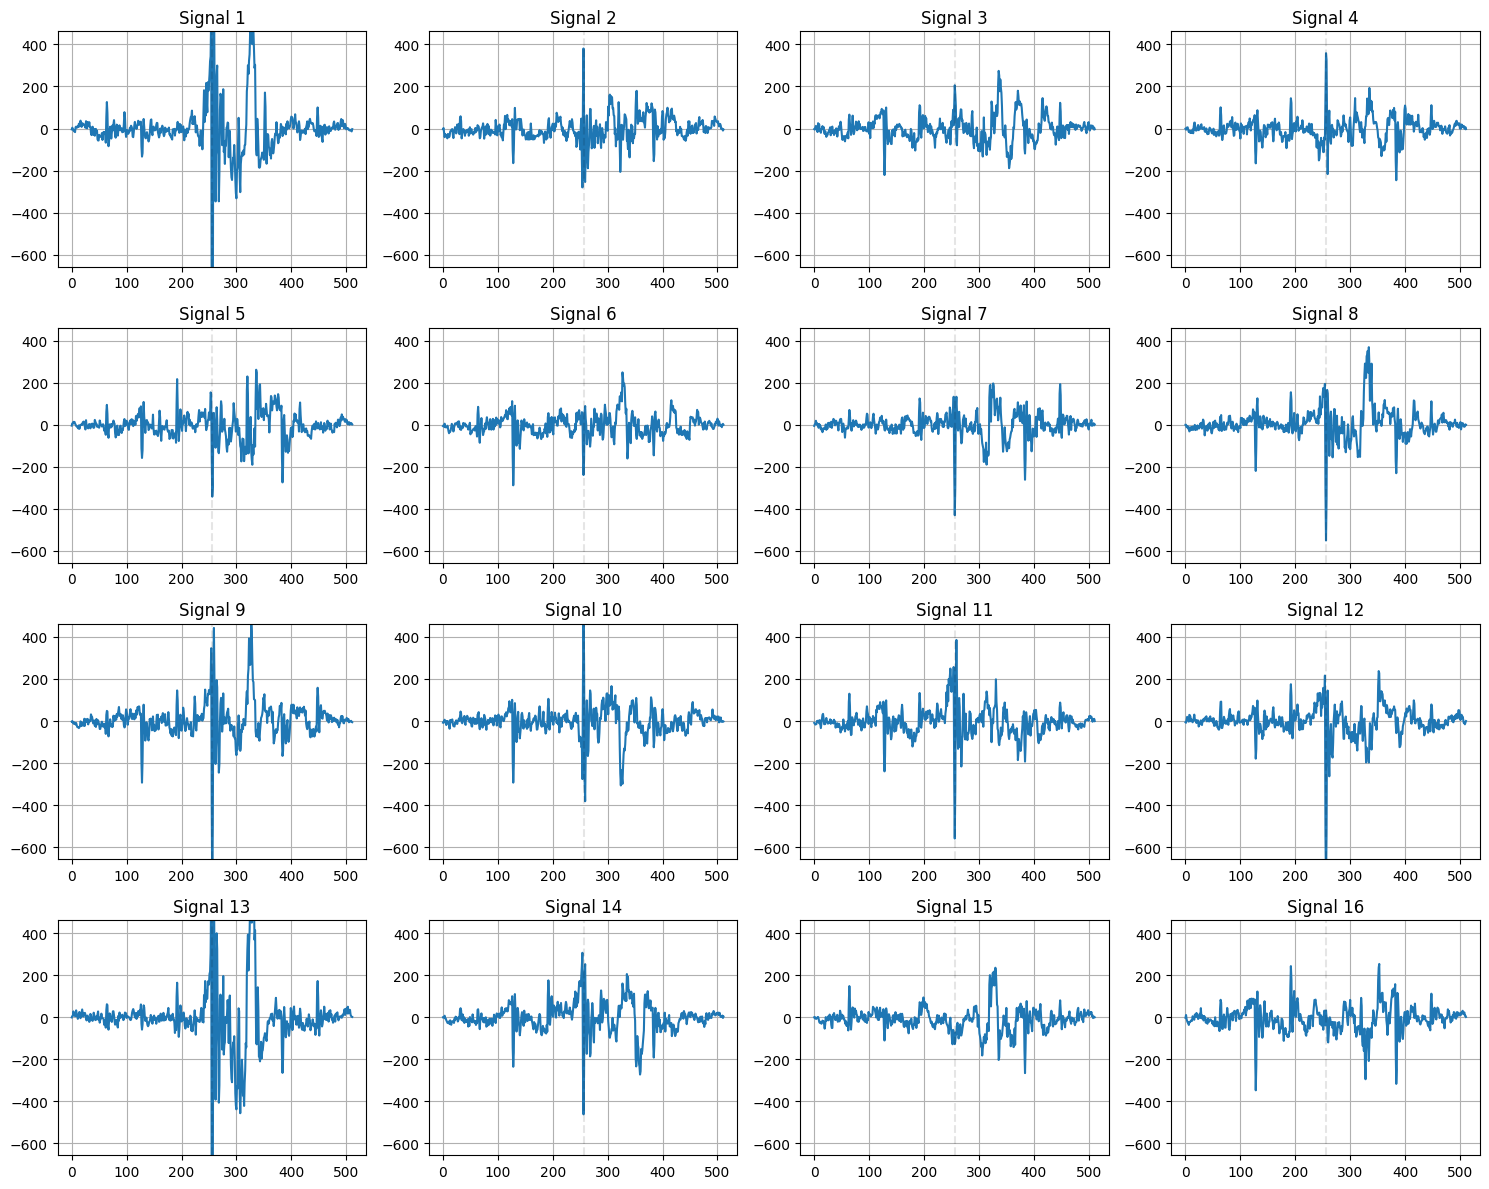

[8/20][0/188]	Loss_D: 0.9139	Loss_G: 2.6506	D(x): 0.2140	D(G(z)): 0.8076 / 0.8060
[8/20][50/188]	Loss_D: 0.8101	Loss_G: 2.3117	D(x): 0.1414	D(G(z)): 0.7176 / 0.7859
[8/20][100/188]	Loss_D: 0.9635	Loss_G: 2.1856	D(x): 0.2278	D(G(z)): 0.7637 / 0.7398
[8/20][150/188]	Loss_D: 1.2316	Loss_G: 2.2794	D(x): 0.1264	D(G(z)): 0.6507 / 0.7076


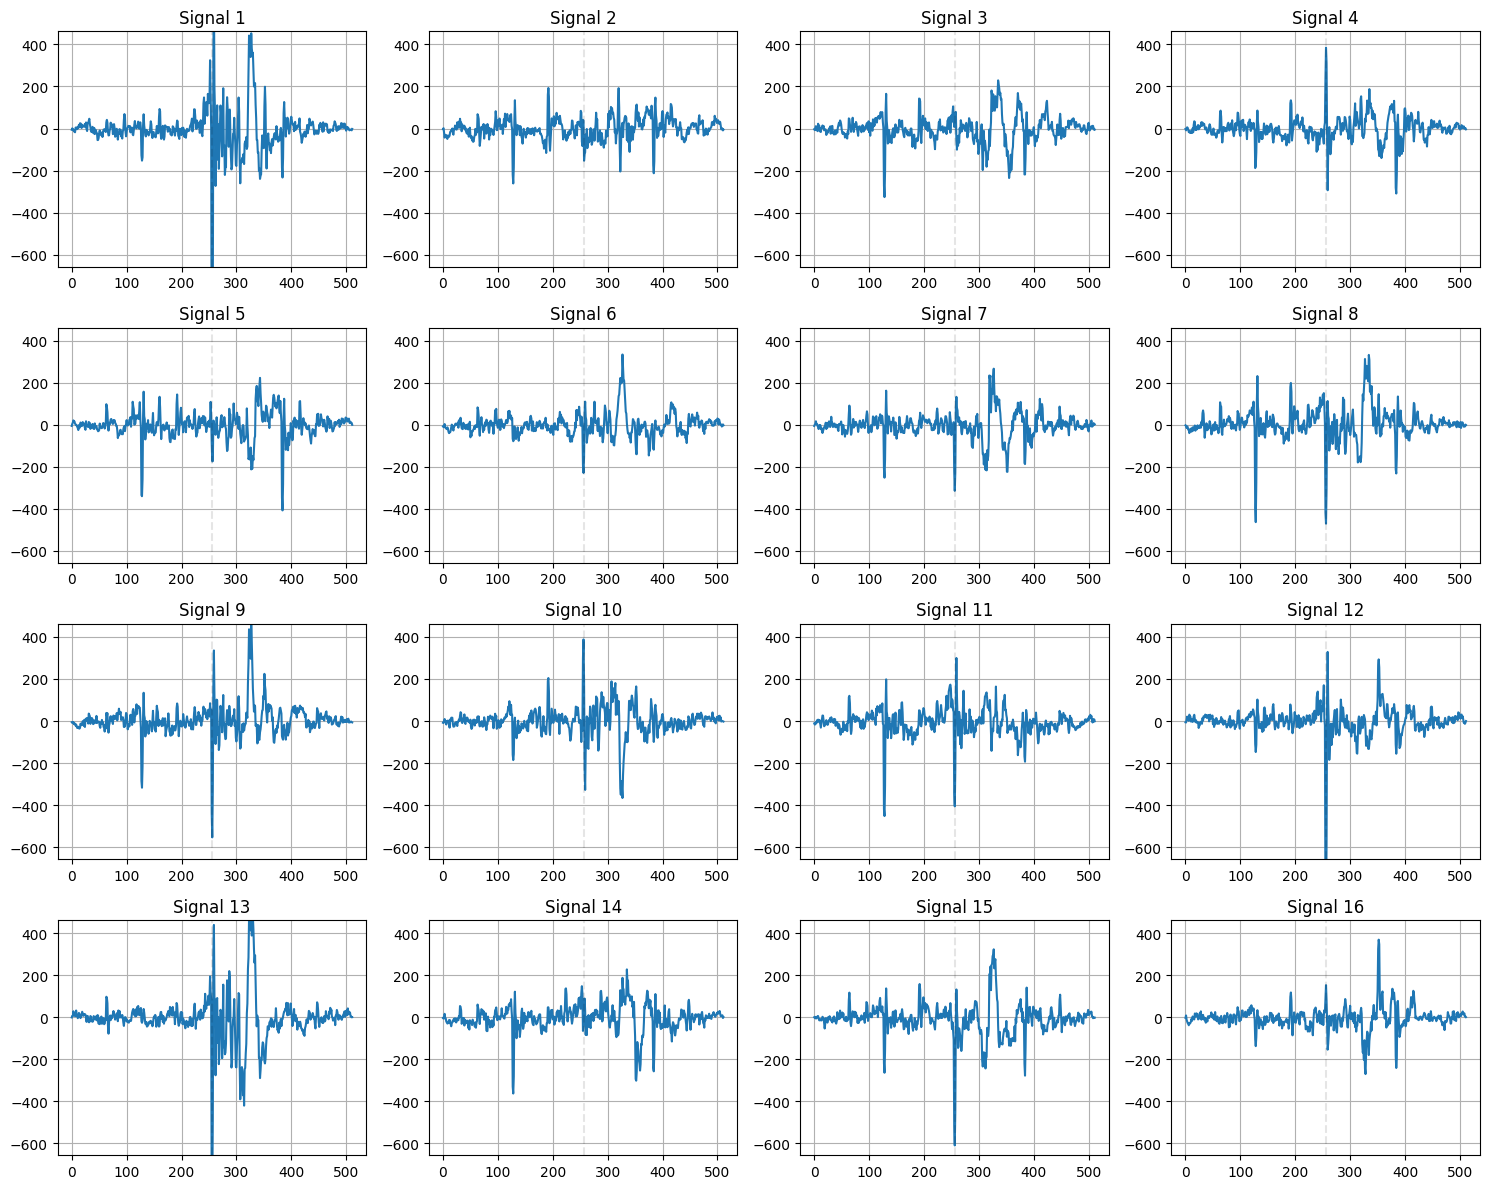

[9/20][0/188]	Loss_D: 0.7340	Loss_G: 3.0779	D(x): 0.0891	D(G(z)): 0.7793 / 0.8297
[9/20][50/188]	Loss_D: 0.9420	Loss_G: 1.8829	D(x): 0.1727	D(G(z)): 0.7683 / 0.6611
[9/20][100/188]	Loss_D: 1.2074	Loss_G: 1.9517	D(x): 0.0803	D(G(z)): 0.6542 / 0.7107
[9/20][150/188]	Loss_D: 0.5561	Loss_G: 2.8239	D(x): 0.1466	D(G(z)): 0.8105 / 0.7678


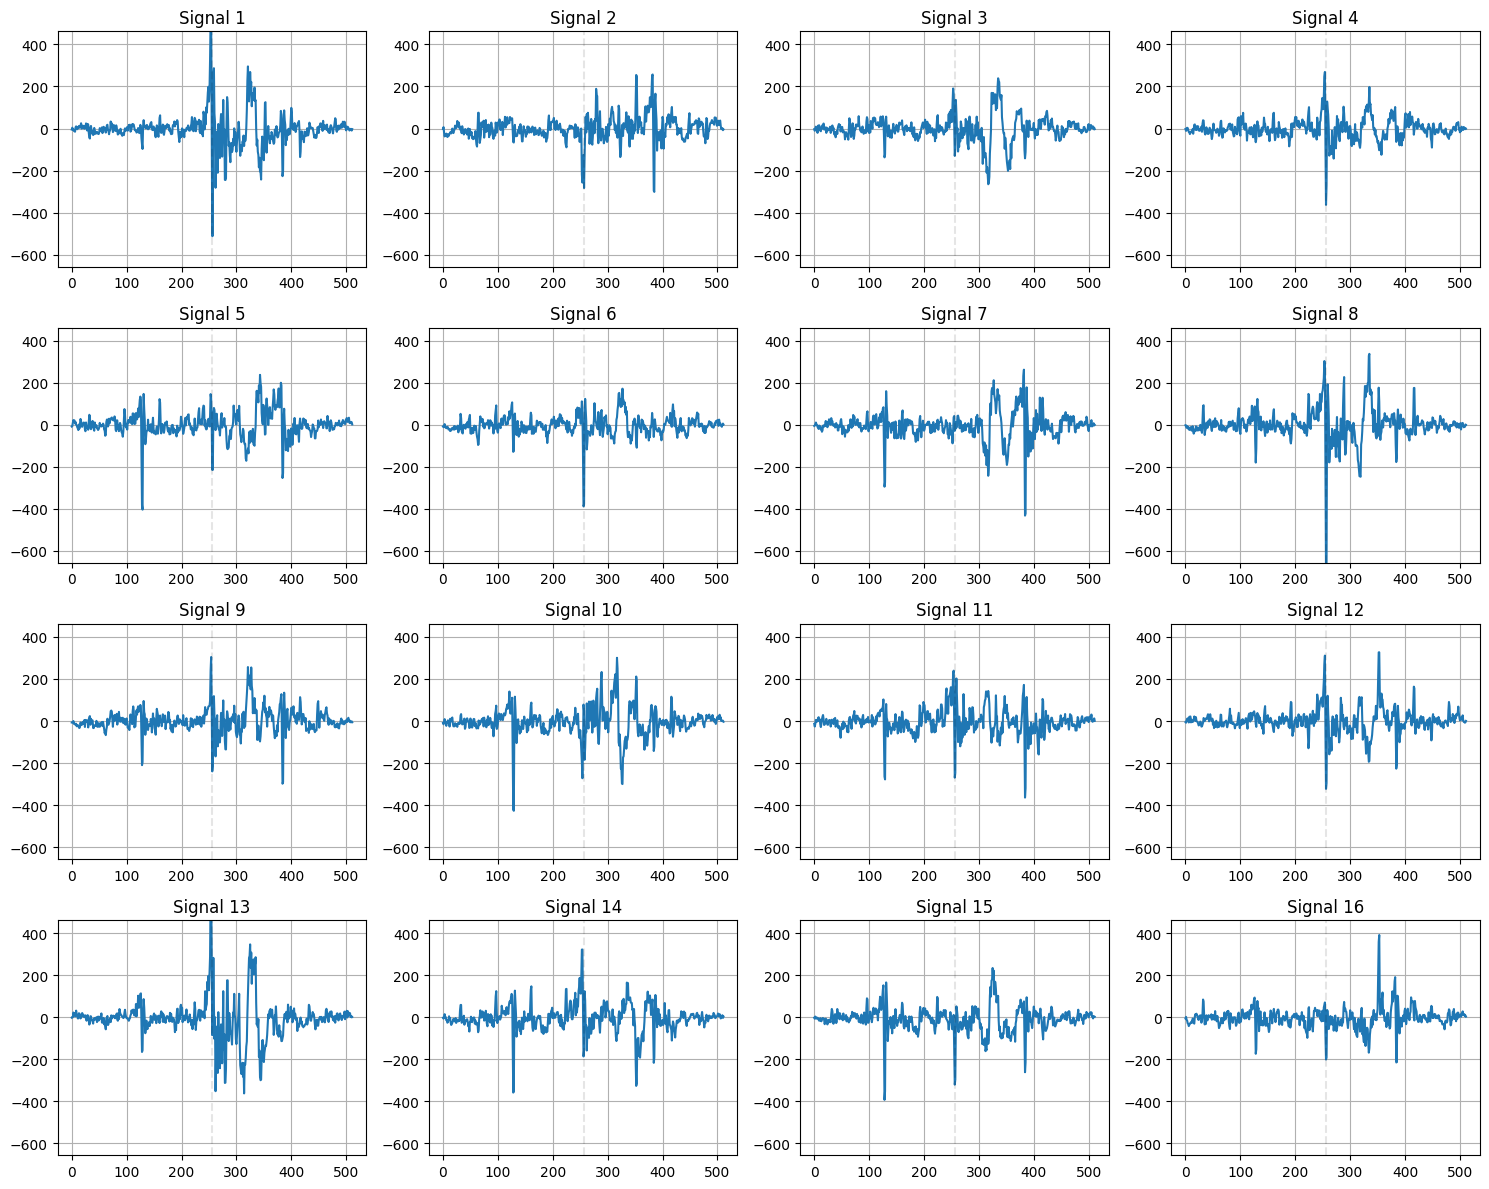

[10/20][0/188]	Loss_D: 0.9184	Loss_G: 2.2801	D(x): 0.1874	D(G(z)): 0.8075 / 0.7451
[10/20][50/188]	Loss_D: 0.7512	Loss_G: 2.2843	D(x): 0.1771	D(G(z)): 0.8404 / 0.7690
[10/20][100/188]	Loss_D: 0.8698	Loss_G: 2.3743	D(x): 0.0952	D(G(z)): 0.7117 / 0.7618
[10/20][150/188]	Loss_D: 0.7081	Loss_G: 3.7109	D(x): 0.1501	D(G(z)): 0.8604 / 0.8441


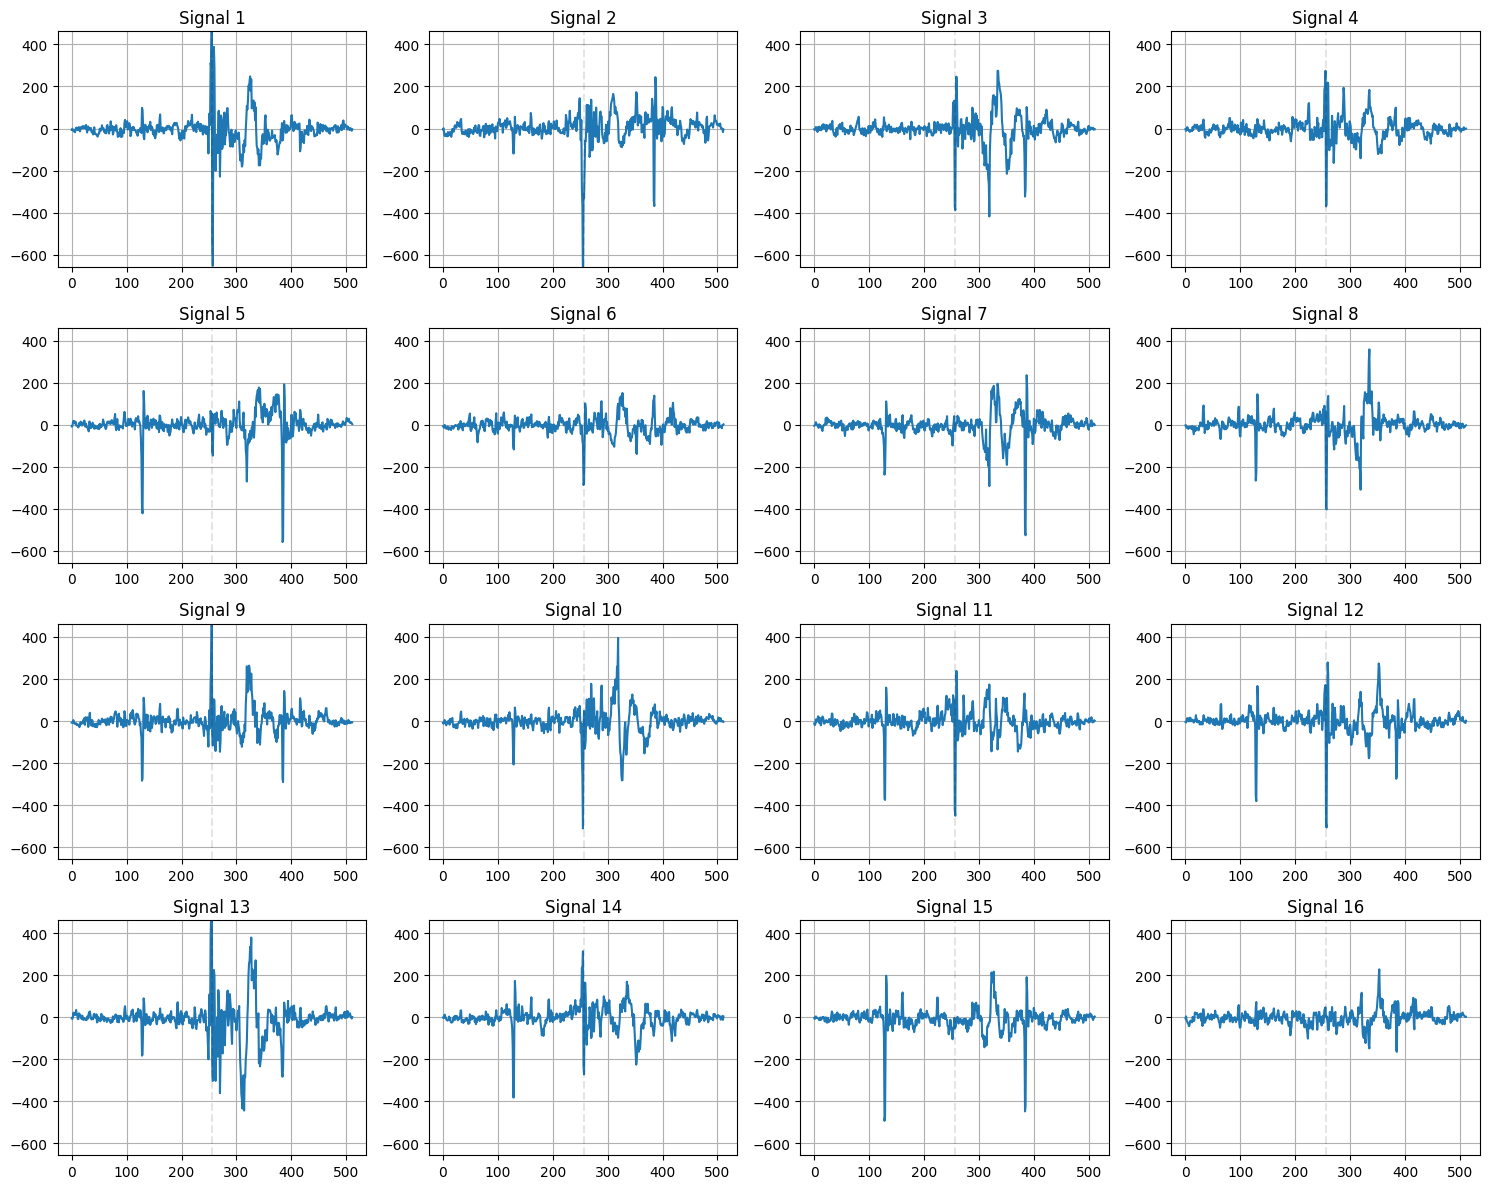

[11/20][0/188]	Loss_D: 0.9294	Loss_G: 2.6851	D(x): 0.2085	D(G(z)): 0.7219 / 0.8025
[11/20][50/188]	Loss_D: 0.6248	Loss_G: 2.6230	D(x): 0.1132	D(G(z)): 0.8147 / 0.7421
[11/20][100/188]	Loss_D: 0.8285	Loss_G: 3.0724	D(x): 0.1931	D(G(z)): 0.7937 / 0.7834
[11/20][150/188]	Loss_D: 0.9457	Loss_G: 2.8318	D(x): 0.1942	D(G(z)): 0.6583 / 0.7894


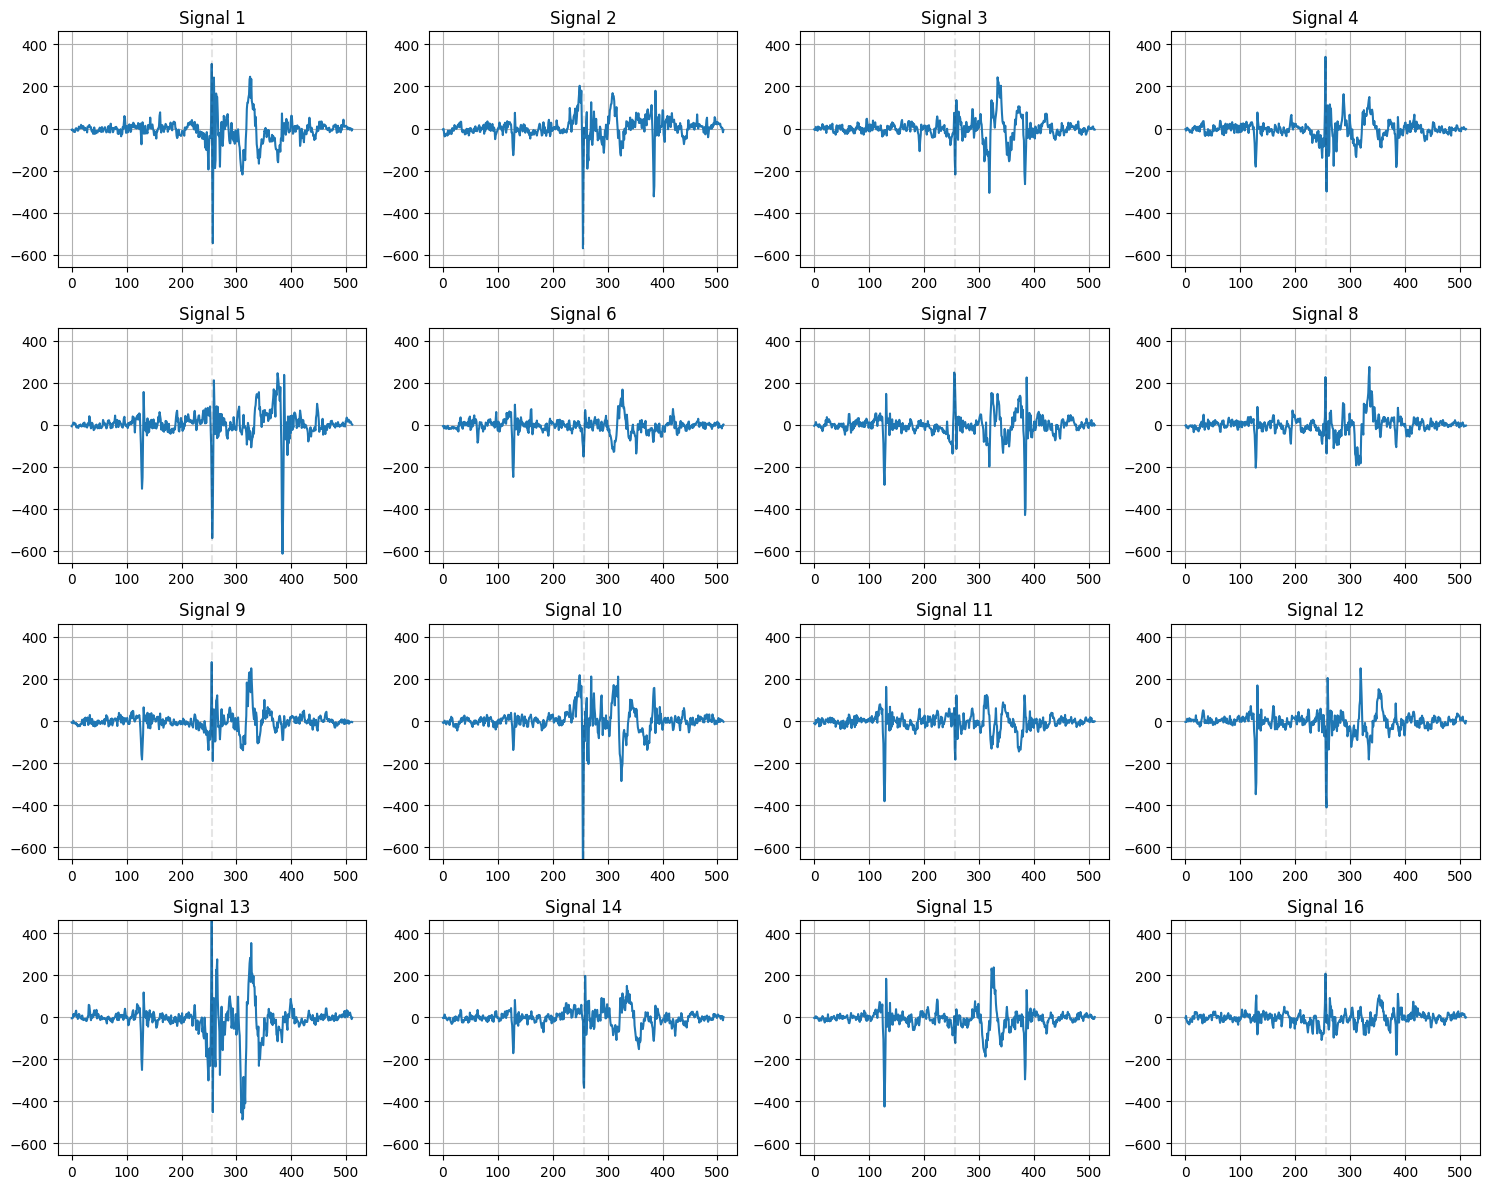

[12/20][0/188]	Loss_D: 0.7456	Loss_G: 2.6950	D(x): 0.1776	D(G(z)): 0.7413 / 0.8150
[12/20][50/188]	Loss_D: 0.6755	Loss_G: 2.9251	D(x): 0.0987	D(G(z)): 0.8173 / 0.8199
[12/20][100/188]	Loss_D: 0.9567	Loss_G: 3.5524	D(x): 0.0983	D(G(z)): 0.8658 / 0.8504
[12/20][150/188]	Loss_D: 1.1073	Loss_G: 2.7873	D(x): 0.2047	D(G(z)): 0.7865 / 0.8393


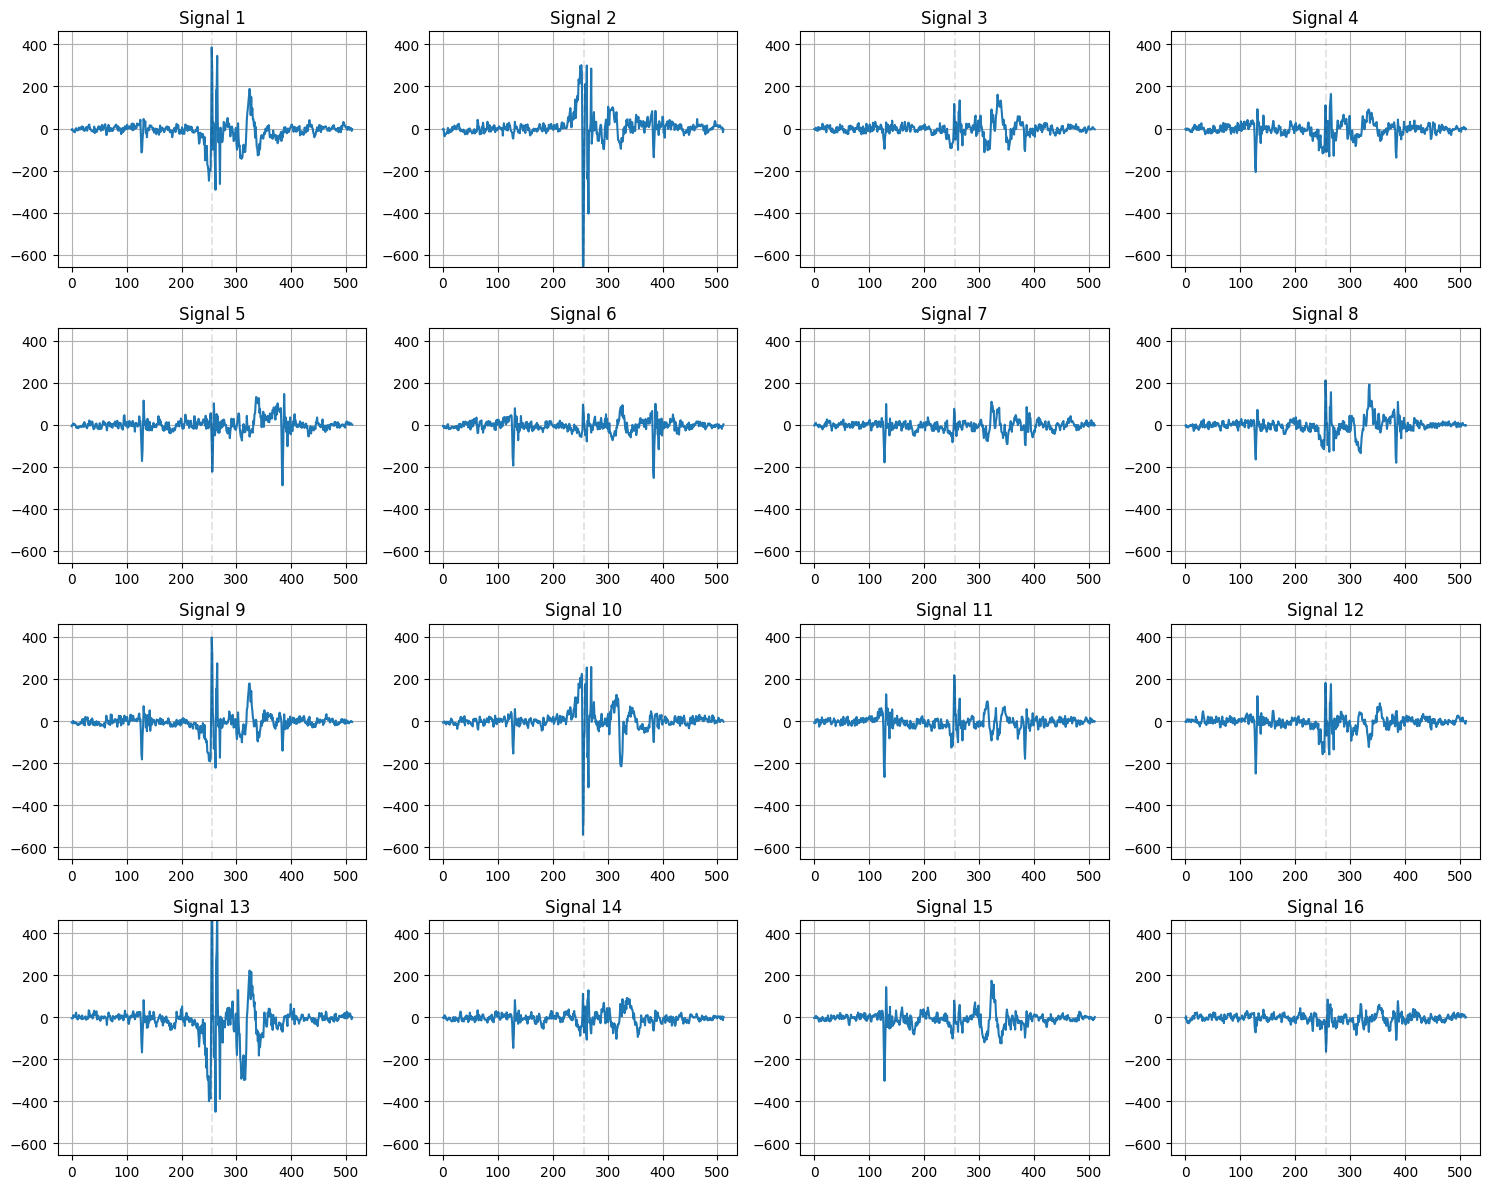

[13/20][0/188]	Loss_D: 0.5244	Loss_G: 2.6250	D(x): 0.1264	D(G(z)): 0.8591 / 0.7804
[13/20][50/188]	Loss_D: 0.9341	Loss_G: 2.1759	D(x): 0.1590	D(G(z)): 0.7782 / 0.7731
[13/20][100/188]	Loss_D: 0.8717	Loss_G: 2.6939	D(x): 0.1662	D(G(z)): 0.8087 / 0.7669
[13/20][150/188]	Loss_D: 0.7078	Loss_G: 2.9688	D(x): 0.0641	D(G(z)): 0.8191 / 0.7974


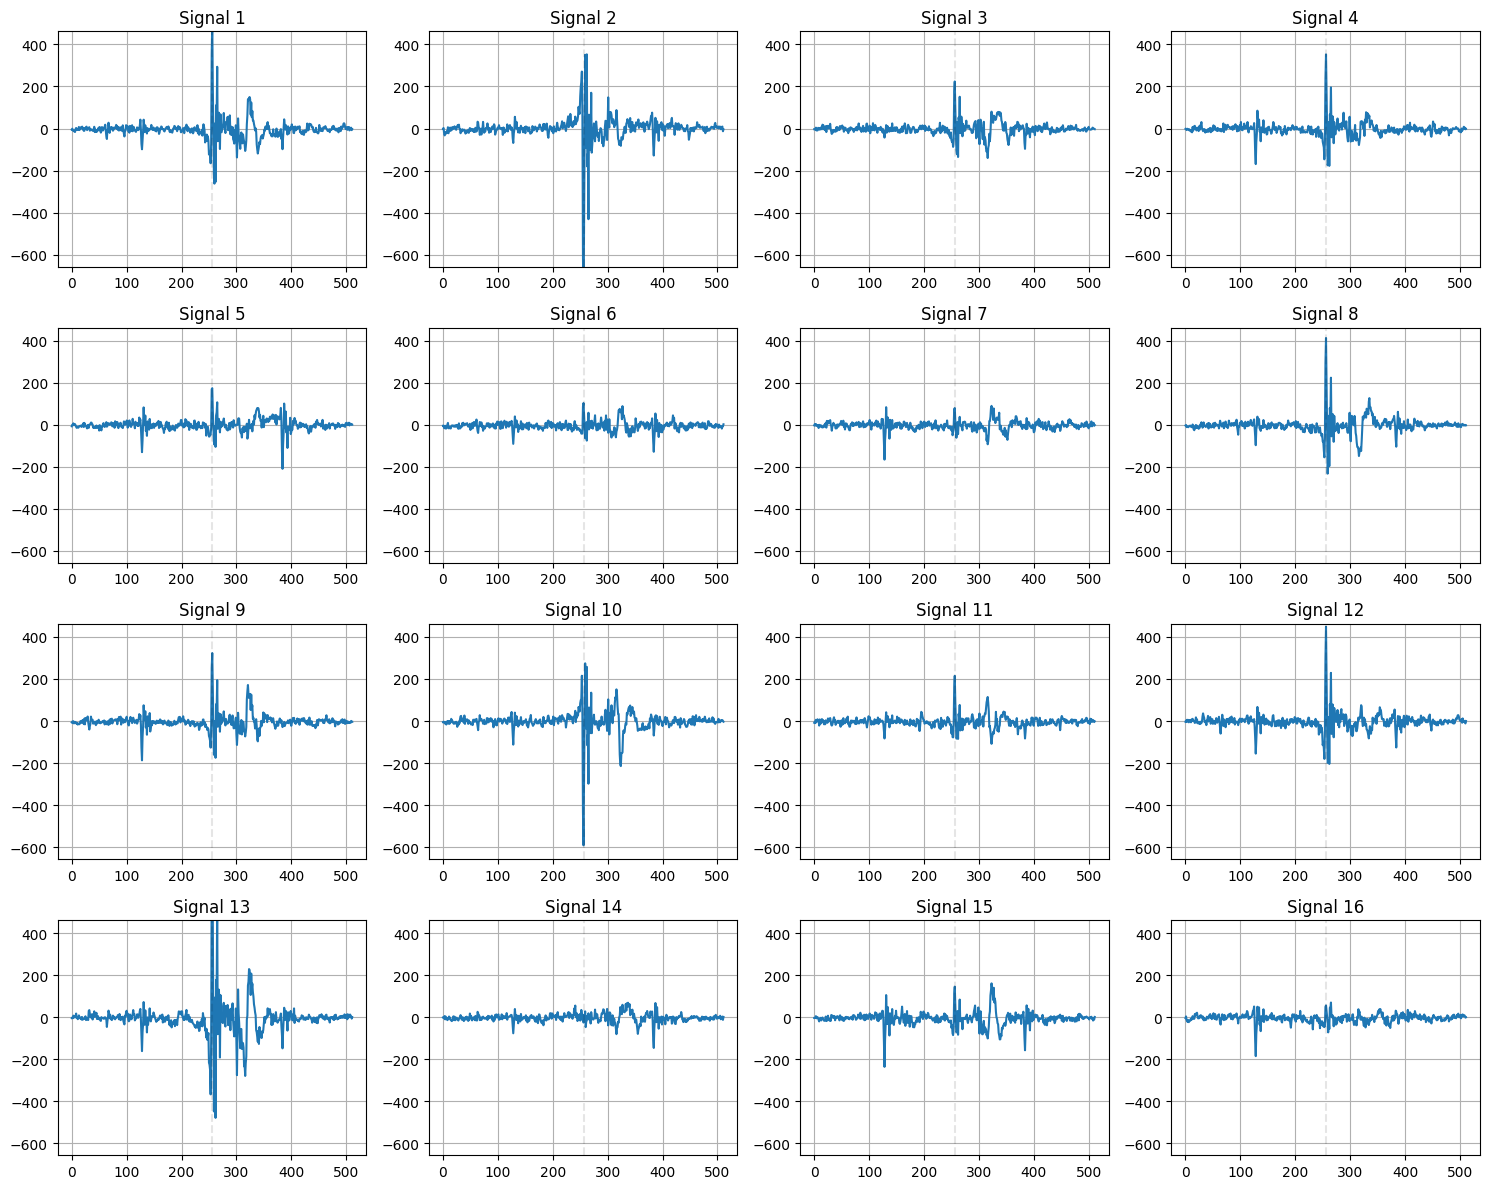

[14/20][0/188]	Loss_D: 0.4797	Loss_G: 2.0861	D(x): 0.1261	D(G(z)): 0.7464 / 0.7815
[14/20][50/188]	Loss_D: 1.3685	Loss_G: 2.5207	D(x): 0.1095	D(G(z)): 0.8095 / 0.8358
[14/20][100/188]	Loss_D: 0.4874	Loss_G: 2.9002	D(x): 0.1775	D(G(z)): 0.8072 / 0.8159
[14/20][150/188]	Loss_D: 0.8536	Loss_G: 2.2374	D(x): 0.0880	D(G(z)): 0.7025 / 0.7950


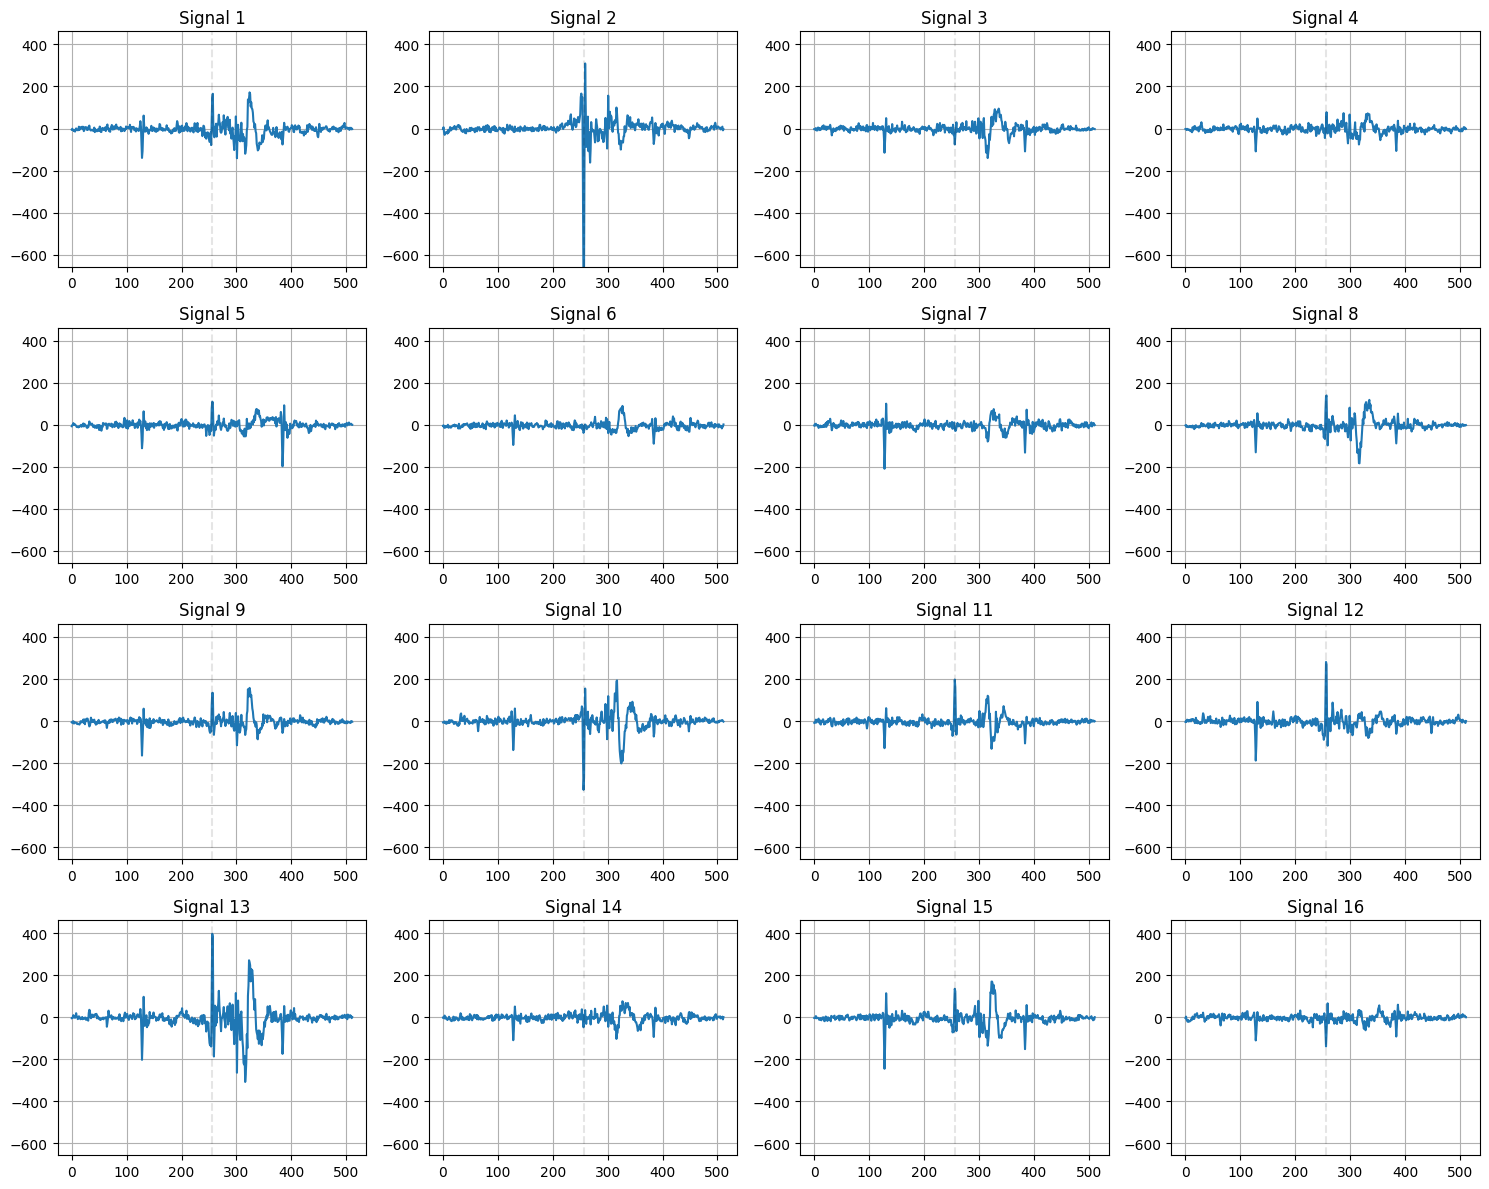

[15/20][0/188]	Loss_D: 0.8594	Loss_G: 1.7302	D(x): 0.1423	D(G(z)): 0.7350 / 0.7190
[15/20][50/188]	Loss_D: 0.8032	Loss_G: 1.8286	D(x): 0.1580	D(G(z)): 0.7534 / 0.6586
[15/20][100/188]	Loss_D: 0.5319	Loss_G: 2.2815	D(x): 0.0354	D(G(z)): 0.8341 / 0.7958
[15/20][150/188]	Loss_D: 0.6676	Loss_G: 2.0590	D(x): 0.1425	D(G(z)): 0.6974 / 0.7066


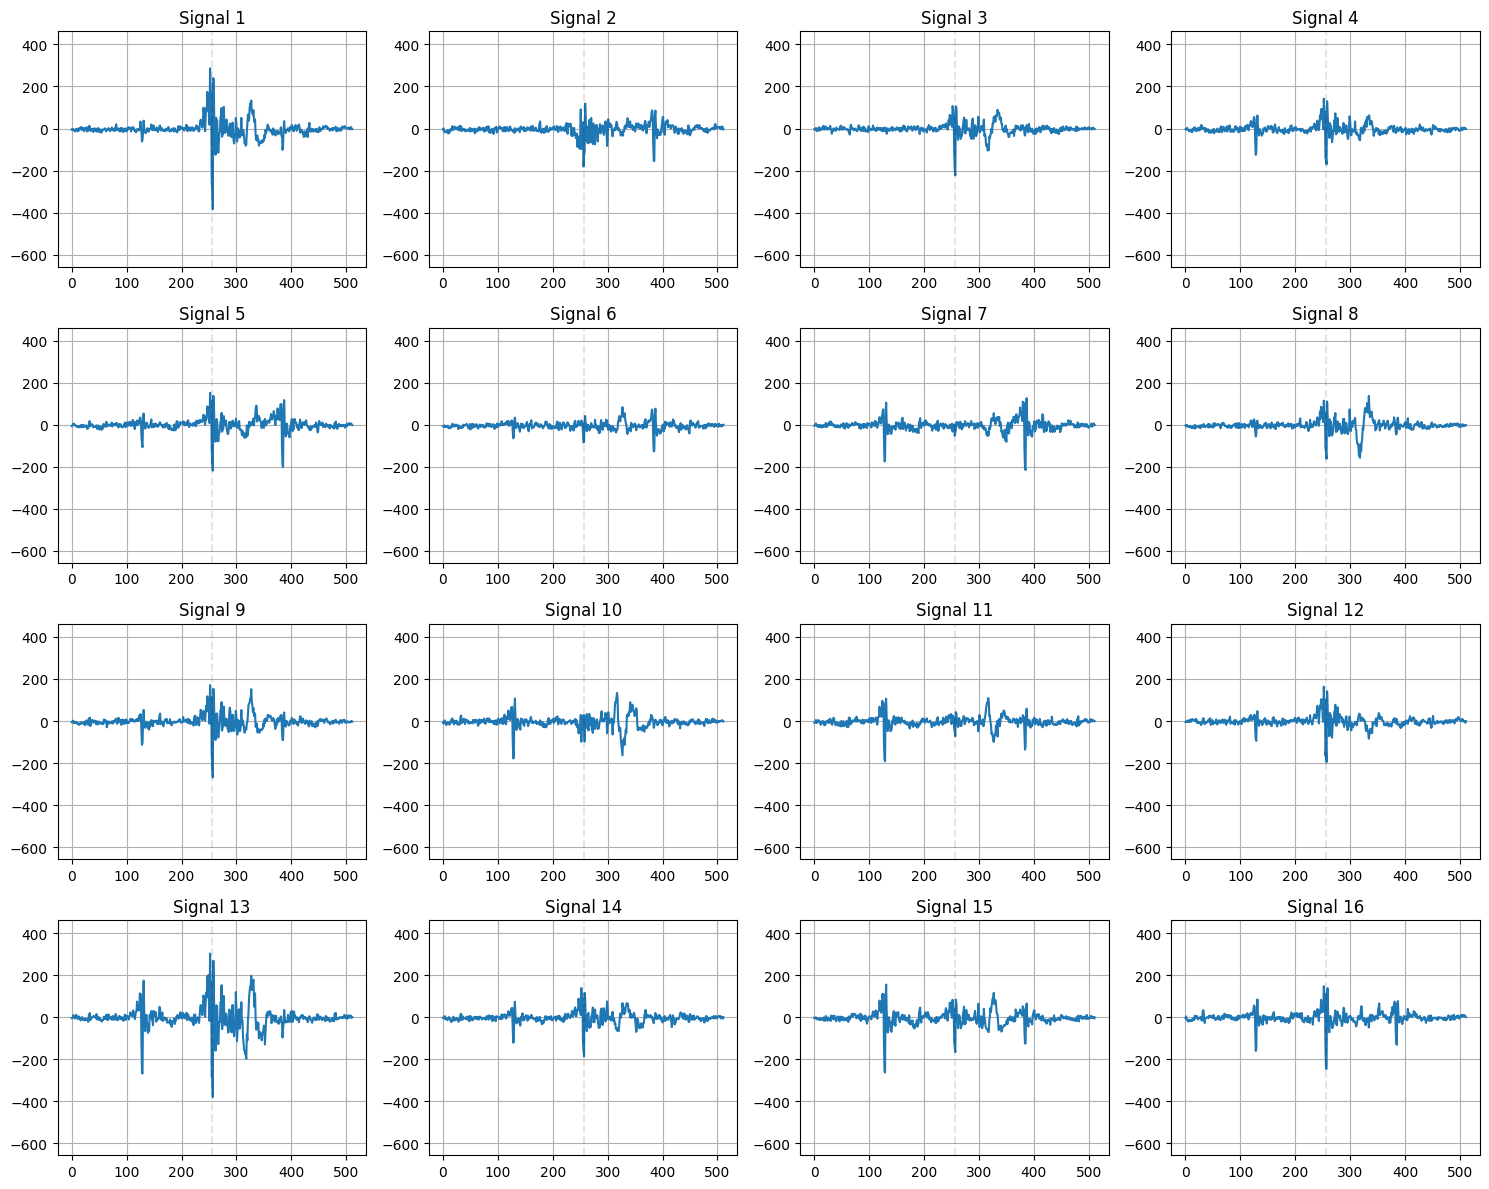

[16/20][0/188]	Loss_D: 0.6401	Loss_G: 3.0993	D(x): 0.1744	D(G(z)): 0.8431 / 0.7993
[16/20][50/188]	Loss_D: 0.8636	Loss_G: 2.6510	D(x): 0.1961	D(G(z)): 0.8138 / 0.8066
[16/20][100/188]	Loss_D: 0.5419	Loss_G: 2.1772	D(x): 0.1591	D(G(z)): 0.7762 / 0.7430
[16/20][150/188]	Loss_D: 0.6671	Loss_G: 2.8820	D(x): 0.1113	D(G(z)): 0.7575 / 0.8359


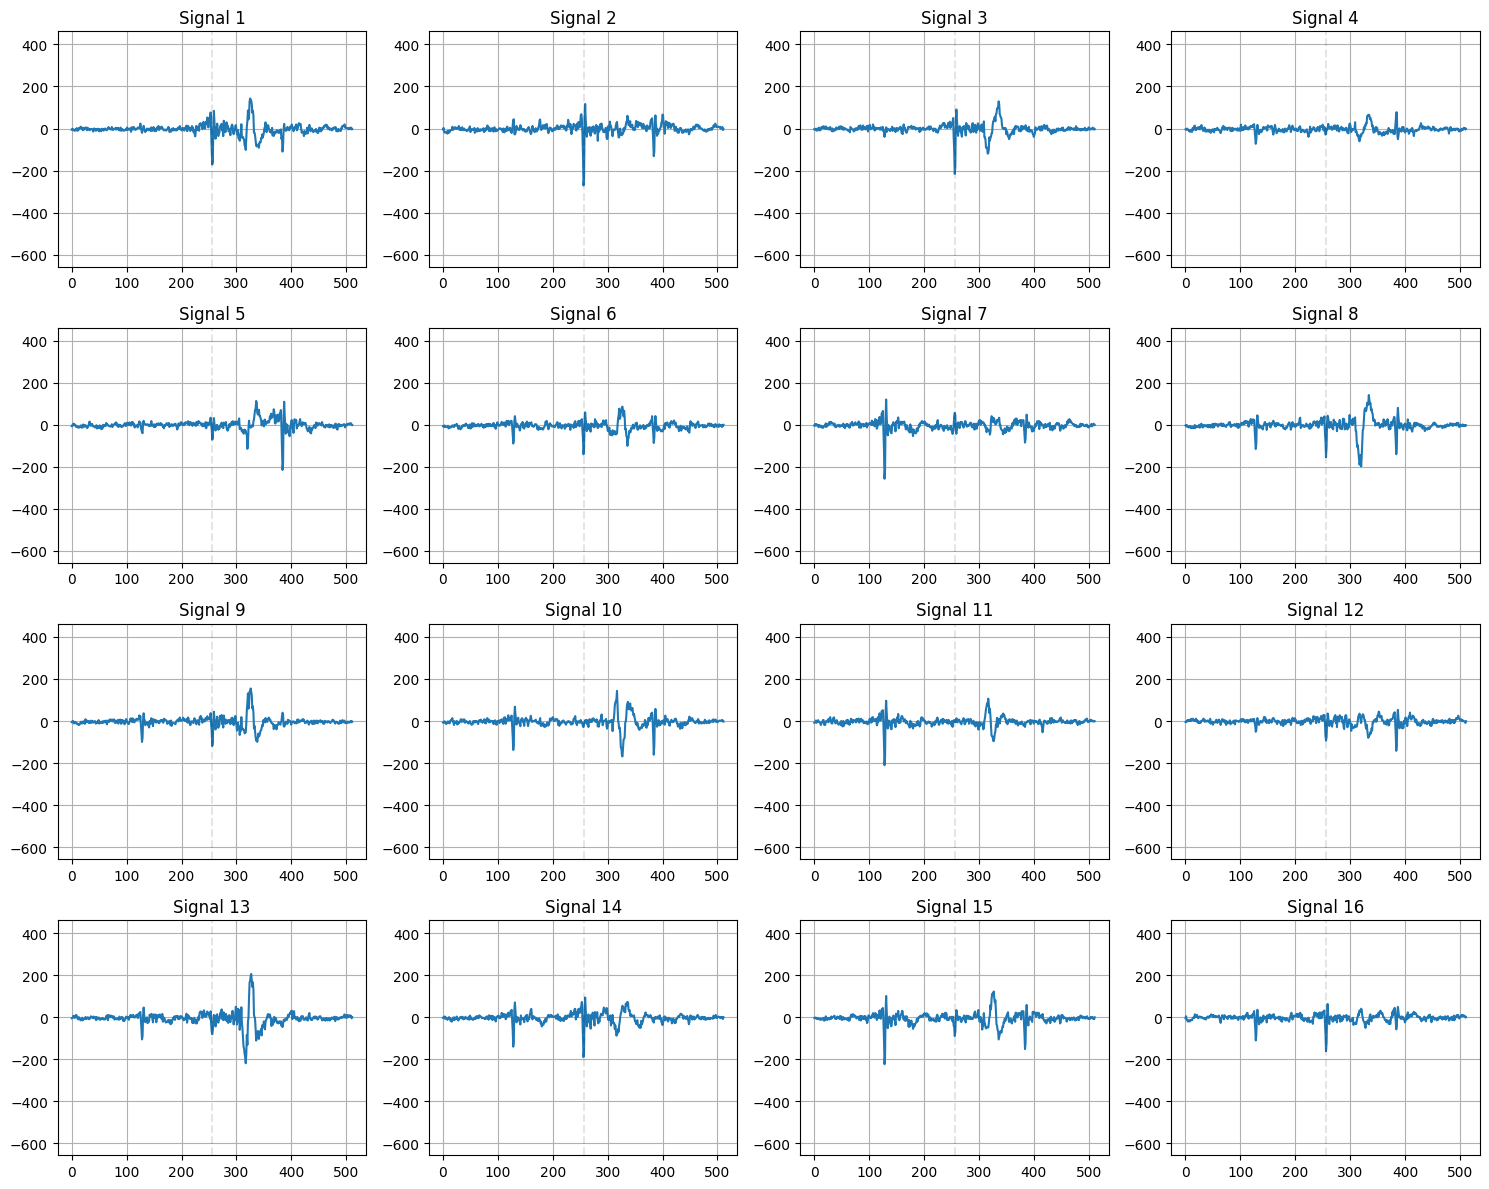

[17/20][0/188]	Loss_D: 0.8995	Loss_G: 2.1995	D(x): 0.1275	D(G(z)): 0.6515 / 0.7477
[17/20][50/188]	Loss_D: 0.7926	Loss_G: 2.6388	D(x): 0.1002	D(G(z)): 0.7751 / 0.7745
[17/20][100/188]	Loss_D: 0.7820	Loss_G: 2.8648	D(x): 0.1740	D(G(z)): 0.7957 / 0.8006
[17/20][150/188]	Loss_D: 0.6428	Loss_G: 2.8428	D(x): 0.0822	D(G(z)): 0.7587 / 0.7518


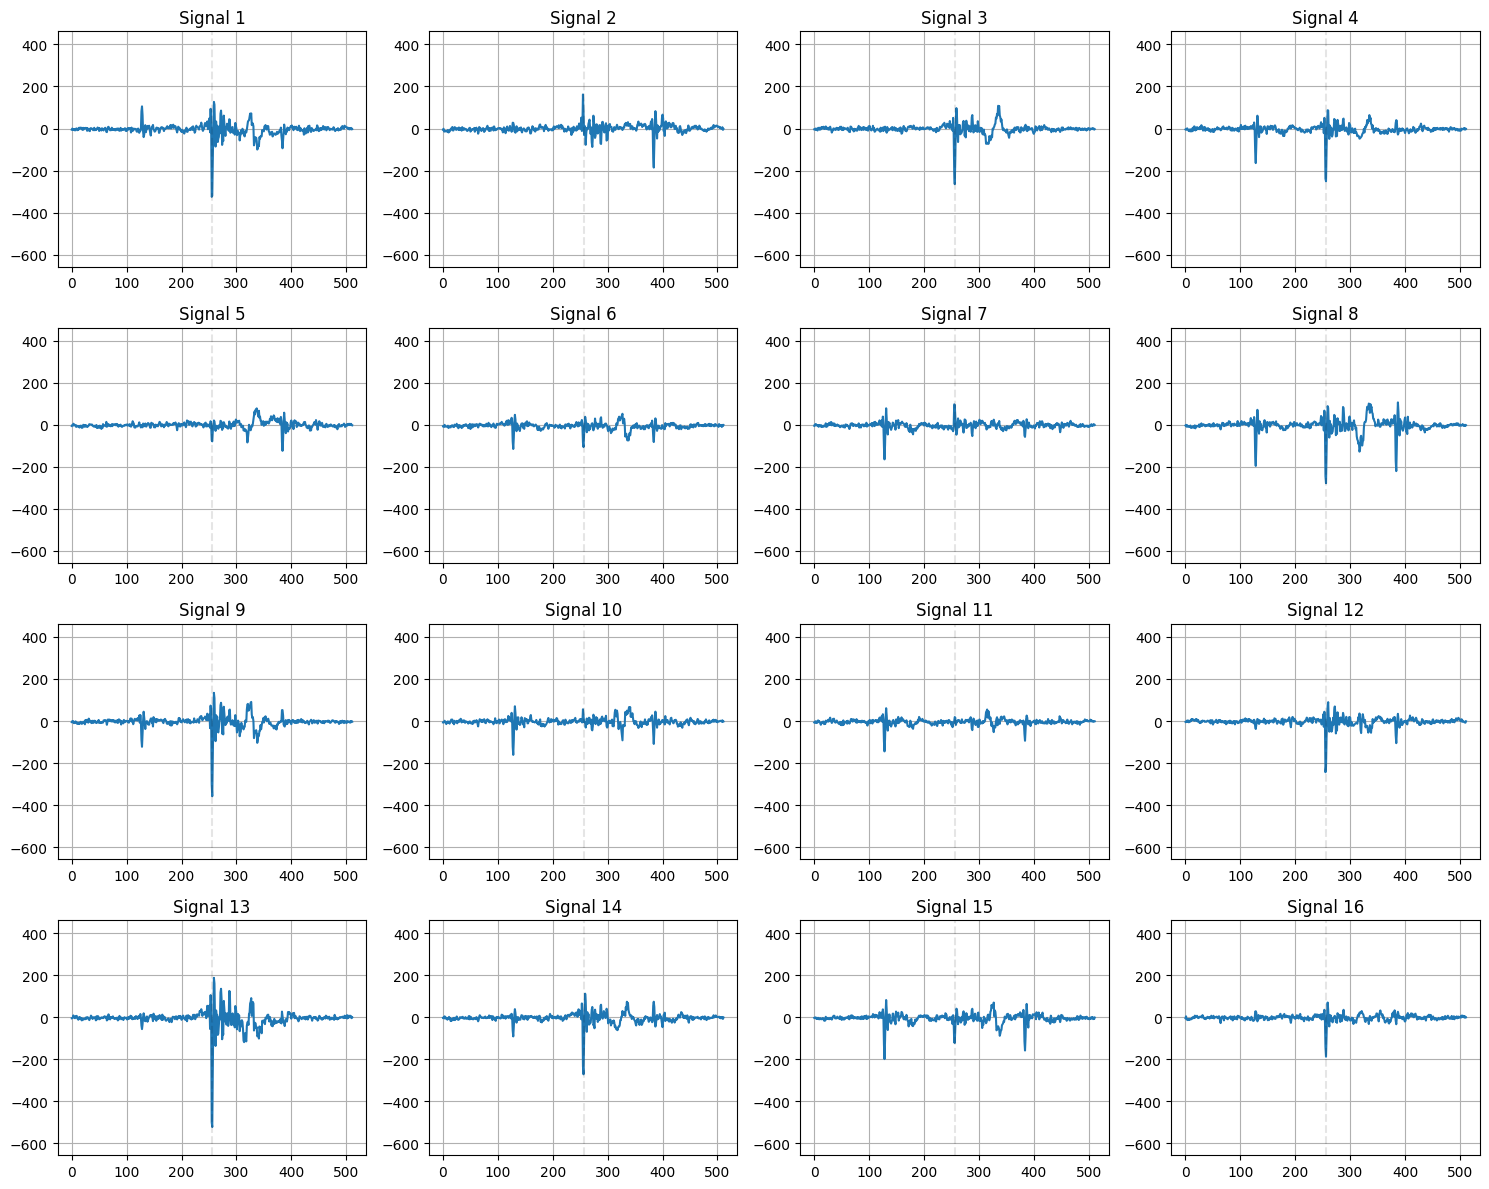

[18/20][0/188]	Loss_D: 0.5937	Loss_G: 1.6333	D(x): 0.1413	D(G(z)): 0.7203 / 0.6881
[18/20][50/188]	Loss_D: 1.1053	Loss_G: 2.5526	D(x): 0.1409	D(G(z)): 0.4435 / 0.8126
[18/20][100/188]	Loss_D: 0.7122	Loss_G: 2.5610	D(x): 0.0952	D(G(z)): 0.8234 / 0.7881
[18/20][150/188]	Loss_D: 0.9386	Loss_G: 2.2599	D(x): 0.1112	D(G(z)): 0.7322 / 0.7625


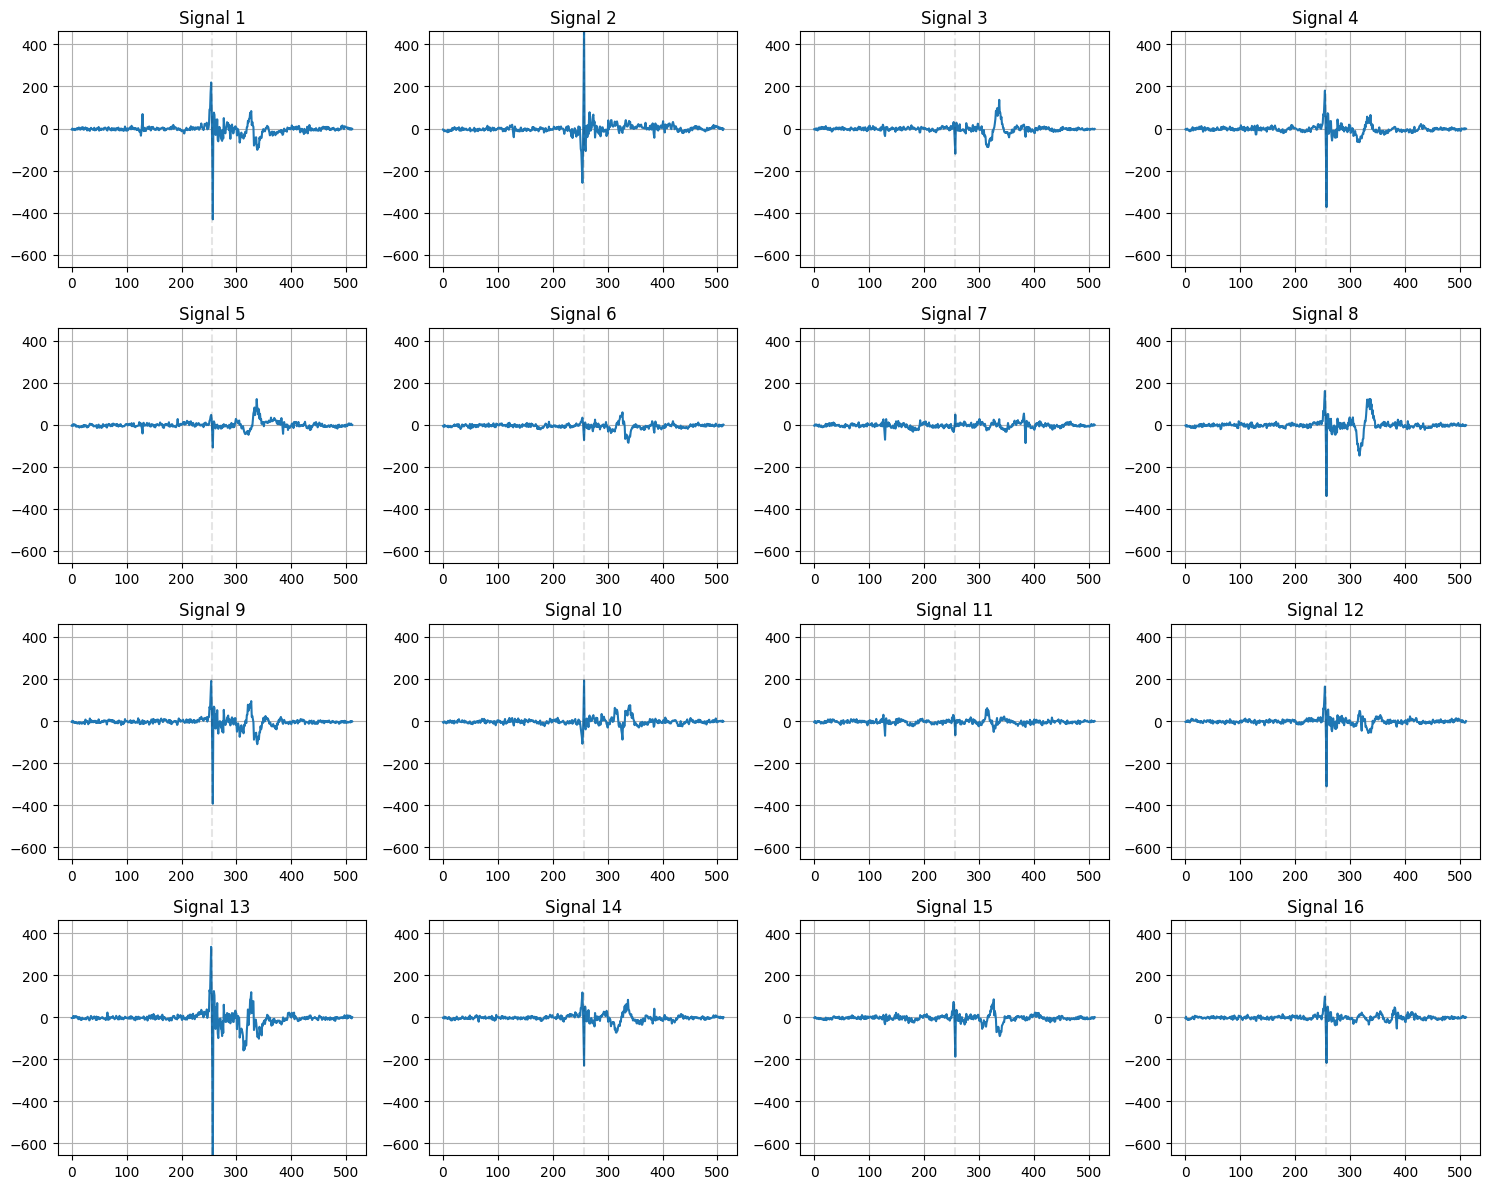

[19/20][0/188]	Loss_D: 0.6236	Loss_G: 2.1856	D(x): 0.1568	D(G(z)): 0.7232 / 0.7904
[19/20][50/188]	Loss_D: 0.9654	Loss_G: 2.0187	D(x): 0.1422	D(G(z)): 0.7565 / 0.7732
[19/20][100/188]	Loss_D: 0.7134	Loss_G: 2.5652	D(x): 0.1678	D(G(z)): 0.7674 / 0.8519
[19/20][150/188]	Loss_D: 0.3946	Loss_G: 2.2100	D(x): 0.0329	D(G(z)): 0.7140 / 0.8129


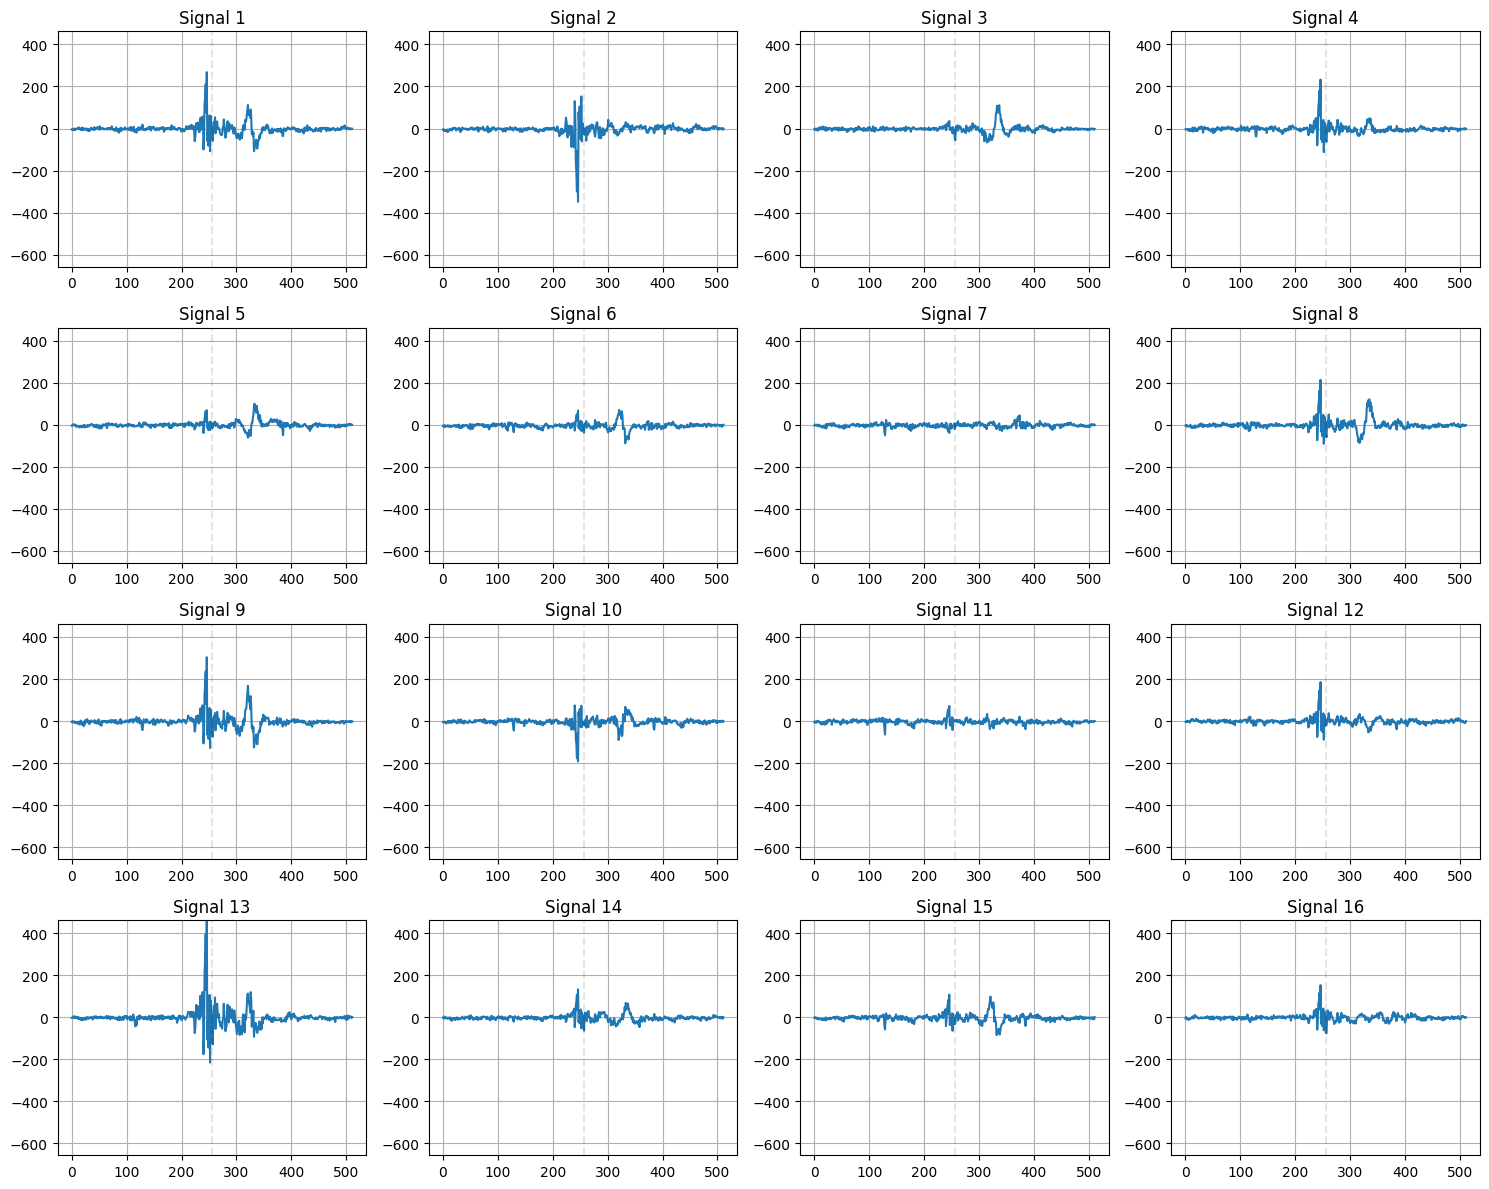

In [162]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_gpu = data.to(device)
        # print(real_gpu.shape)
        b_size = real_gpu.size(0)

        # determine which index of batch to flip on
        flip_mask = torch.rand(b_size) < flip_p

        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)

        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, device=device)
        # Generate fake signal batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        # Calculate gradients of discriminator parameters
        D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.FloatTensor(b_size).uniform_(0.75, 1.25)
        label = torch.where(flip_mask, 1.0 - label, label).to(device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Calculate gradients of generator parameters
        G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1 

    
    with torch.no_grad():
        fake_signals = netG(fixed_noise).detach().cpu()
        fig, axes = plt.subplots(4, 4, figsize=(15, 12))

        axes = axes.flatten()

        # plot each signal on a separate subplot
        for i, ax in enumerate(axes):
            x = np.arange(fake_signals.size(dim=2))
            y = fake_signals[i, :, :].flatten()
            y = y * dataset.scaling_factor
            y = y * dataset.std + dataset.mean
            ax.plot(x, y)

            ax.axvline(x=256, color='black', linestyle='--', alpha=0.1)
            ax.set_title(f'Signal {i+1}')
            ax.grid(True)
            ax.set_ylim(common_ylim_signal)

        for i in range(512, 8*4):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_%d.png' % epoch)
        plt.show()
    
    # print(time.time())
    signal_list.append(fake_signals)

### Gradients

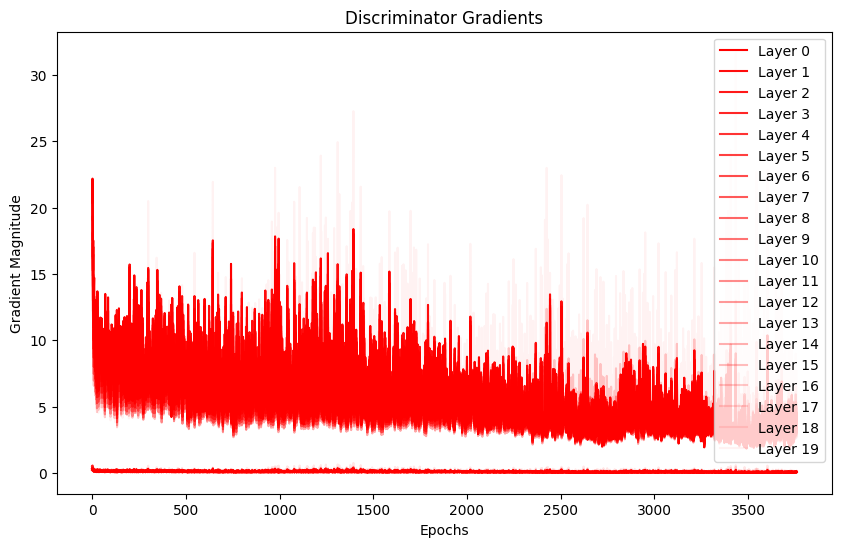

In [163]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

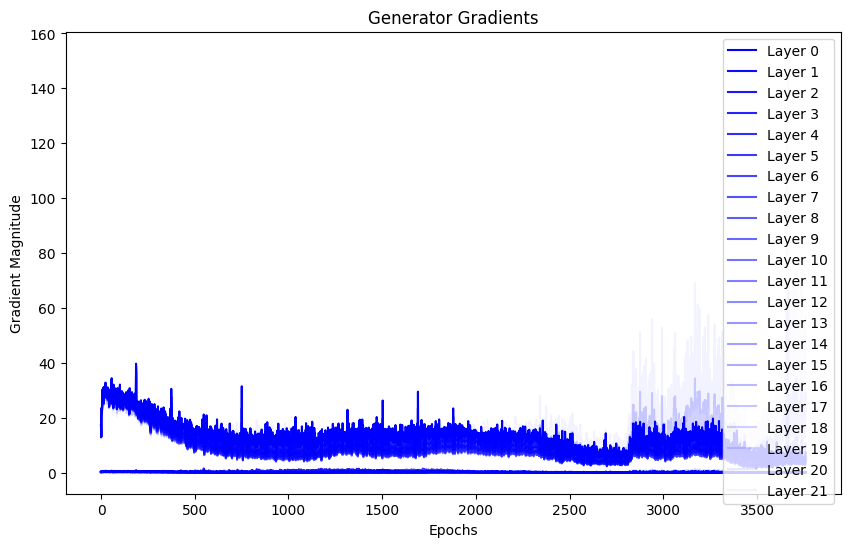

In [164]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

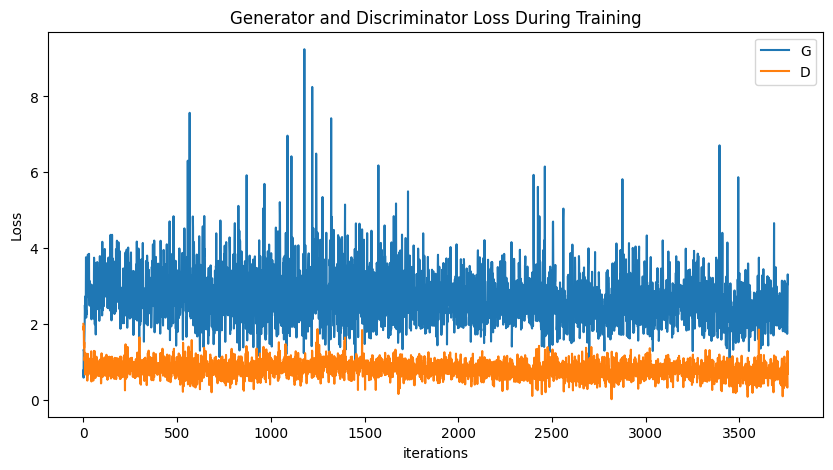

In [165]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generated Signals

torch.Size([32, 1, 512])


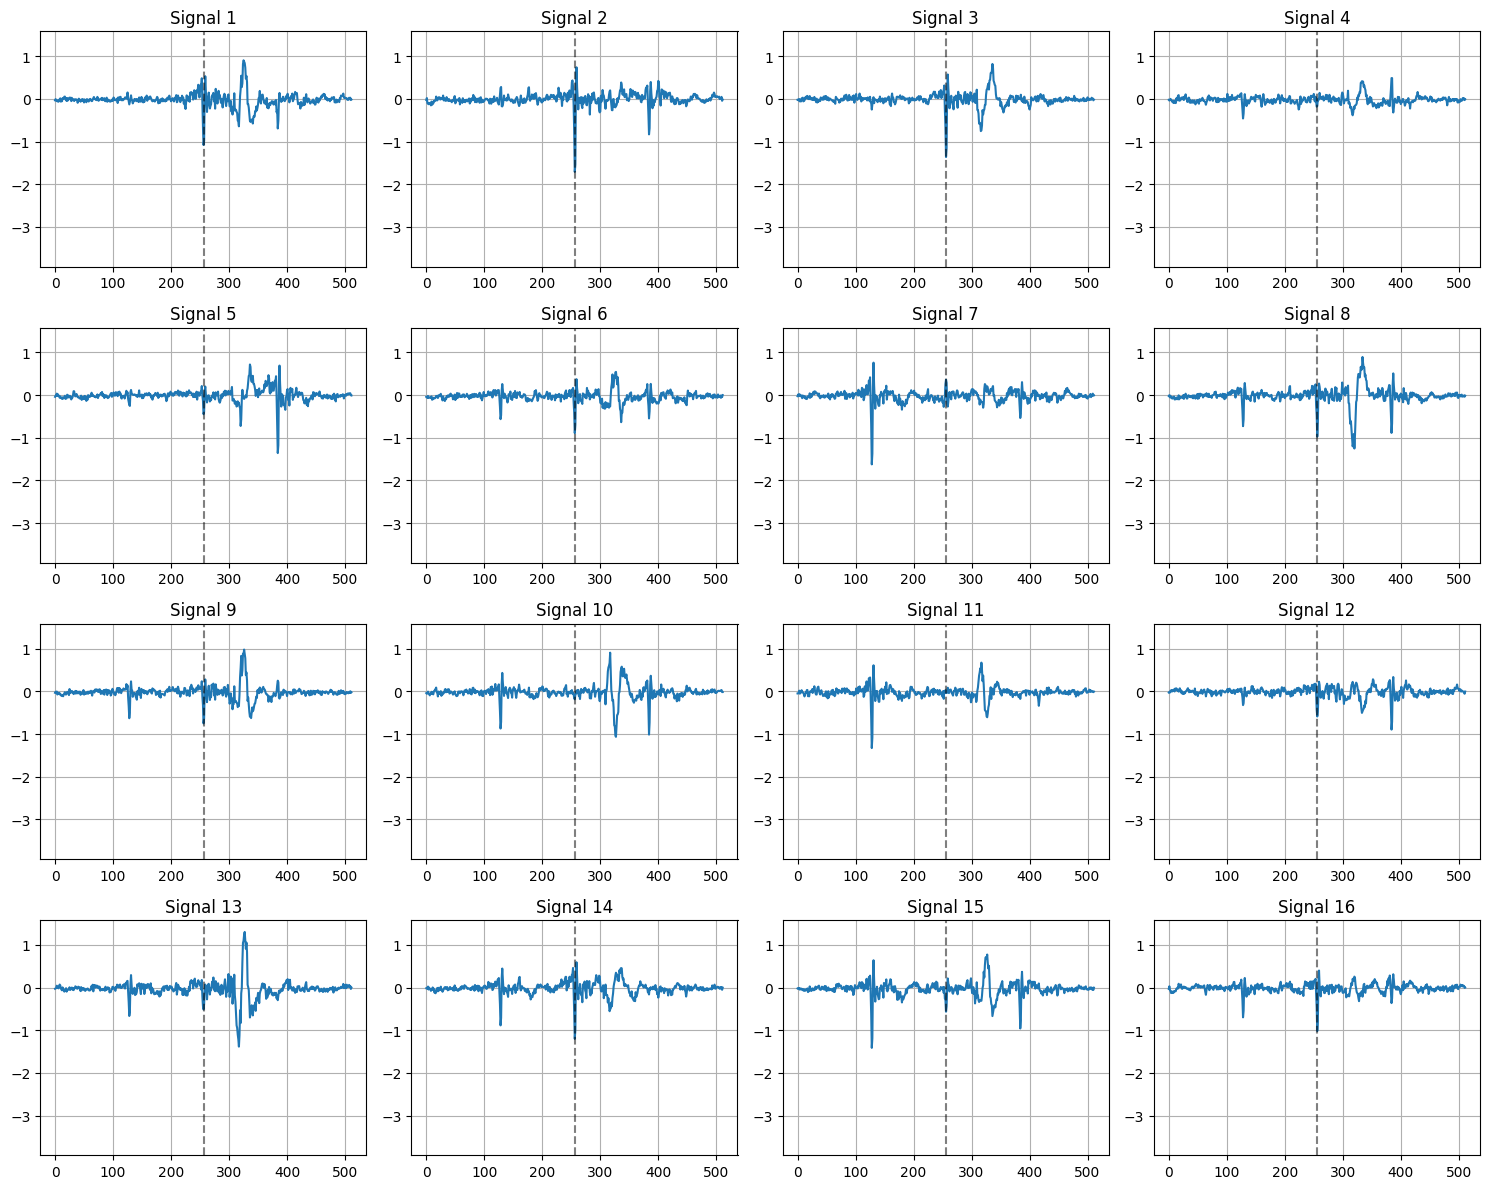

In [166]:
batch = signal_list[16]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [167]:
# # Path to the folder containing PNG images
# image_folder = '../data/gw-dcgans-images'

# # Get a list of image filenames in the folder
# image_filenames = sorted([filename for filename in os.listdir(image_folder) if filename.endswith('.png')])

# # Load images and create an animation
# def update(frame):
#     img_path = os.path.join(image_folder, image_filenames[frame])
#     img = Image.open(img_path)
    
#     # Clear the previous plot
#     plt.clf()
    
#     # Display the image without cropping and centered
#     plt.imshow(img, aspect='auto')
#     plt.axis('off')

# fig = plt.figure(figsize=(8, 8))

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(image_filenames), interval=1000, repeat_delay=1000)

# # Display the animation as HTML (for Jupyter Notebook) or save it to a file
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Save the animation as an .mp4 video
# output_filename = '../data/gw-dcgans-mp4/signals.mp4'
# ani.save(output_filename, writer='ffmpeg', codec='libx264', fps=8, dpi=100, bitrate=1800)

# print(f'Animation saved as {output_filename}')

In [168]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)
